# Pump it Up: Data Mining the Water Table. Bombas de agua en Tanzania

Objetivo Principal: Predecir que bombas de aguas estan defectuosas en Tanzania, si son funcionales, funcionales pero necesitan reparación o no son funcionales, para promover el acceso a agua limpia y potable para las comunidades de Tanzania.

### Importar librerías

Importar las librerías necesarias que se utilizan en el proceso de Machine Learning.

In [1]:
# Manipulación de datos.
import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
import re
from sklearn.preprocessing import LabelEncoder

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler
import pickle

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

### Cargar los datasets y construir una tabla juntando ambas tablas de Trains y Labels

Voy a proceder a cargar los datasets, de entrenamiento, etiquetas y los de test.

In [2]:
train_df = pd.read_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\Training Set Values.csv")
label_df = pd.read_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\Training Set Labels.csv")
test_df = pd.read_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\Test Set Values.csv")
submission_format_df = pd.read_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\SubmissionFormat.csv")

Como primer abordaje que quiero saber es la cantidad de datos que posee cada dataframe cargado.

In [3]:
print('Tamaño de la tabla train:', train_df.shape[0])
print('Tamaño de la tabla label:', label_df.shape[0])
print('Tamaño de la tabla test:', test_df.shape[0])
print('Tamaño de la tabla test:', submission_format_df.shape[0])

Tamaño de la tabla train: 59400
Tamaño de la tabla label: 59400
Tamaño de la tabla test: 14850
Tamaño de la tabla test: 14850


Podemos observar que ambos dataframe de train y label poseen la misma cantidad de datos (59400), por lo que es posible realizar un merge de forma eficiente y correcta. En cuanto al dataframe de prueba y el formato de submision contienen (14850).

Ahora haremos un .isin para saber si todos los ID que estan en el dataframe train estan de la misma forma en el dataframe label y así confirmar su merge.

In [4]:
print('ID en la tabla label', train_df['id'].isin(label_df['id']).value_counts())

ID en la tabla label id
True    59400
Name: count, dtype: int64


Vemos que nos da como output 59.400 que el total de datos de ambos dataframes, por lo tanto, no hay ID's perdidos.

Procedo a mergear ambas tablas para crear un dataframe completo con sus etiquetas, mediante un left join con merge.

In [6]:
full_df = pd.merge(train_df, label_df, on = 'id', how = 'left')

Muestro las primeras 5 filas con un .head() para comprobar que se cargaron y juntaron correctamente ambas tablas, añandiendo la nueva variable status_group que son las etiquetas si son funcionales, funcionales pero necesitan reparacion o no funcionales, las bombas de agua de Tanzania.

In [7]:
full_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [8]:
full_df.shape

(59400, 41)

Comprobado que existen 59.400 filas y 41 varibles/columnas en el full_df.

Compruebo valores únicos de ID

In [9]:
print('Valores únicos de ID presentes en la tabla full_df:', len(full_df['id'].unique()))

Valores únicos de ID presentes en la tabla full_df: 59400


### Preprocesado y limpieza de datos

Para tener una información general de todas nuestras variables hacemos un ".info()" para saber si que tipo de datos tiene cada variable y ver cuantos datos poseen cada variables y detallar a simple vista de valores missing.

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Agrupo en dos variables, el grupo de variables de tipo object o categorica y en otro grupo las de tipo numerico para poder hacer un .describe() y evaluar las variables.

In [11]:
cat_cols = full_df.select_dtypes(include=['object']).columns
num_cols = full_df.select_dtypes(exclude=['object']).columns

In [12]:
full_df[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,...,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,...,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [13]:
full_df[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


A simple vista puedo observar que de las variables tipo object/categoricas, se encuentran valores missing en las variables (funder, installer, wpt_name, subvillage, public_meeting, scheme_management, scheme_name & permit). Relativamente a las variables numericas no presentan valores missing, pero si valores outliers en algunas variables, por lo que tendremos que ver su distribucion mediante gráficos y ver porque se alejan tanto de sus medias.

In [14]:
num_object_cols = len(cat_cols)
print(f"Número de columnas de tipo objeto: {num_object_cols}")

Número de columnas de tipo objeto: 31


In [15]:
num_int_float_cols = len(num_cols)
print(f"Número de columnas de tipo númerico: {num_int_float_cols}")

Número de columnas de tipo númerico: 10


Contamos 31 variables de tipo objeto/categórica y 10 de tipo númerico.

En mi primer abordaje veo que la variable data_recorded y construction_year, por si solas no me daran mucha información relevante para el modelo, por lo que creare una nueva variable, restando data_recorded - construction_year y saber cuantos años tiene el pozo.

In [16]:
full_df['date_recorded'] = pd.to_datetime(full_df['date_recorded'])
full_df['year_recorded'] = full_df['date_recorded'].dt.year

# Calcular la media de 'construction_year' excluyendo ceros
mean_year = full_df[full_df['construction_year'] > 0]['construction_year'].mean()

# Asegurarse de que 'construction_year' tiene sentido; reemplazar 0 con NaN y imputación por la media
full_df['construction_year'] = full_df['construction_year'].replace(0, np.nan)
full_df['construction_year'].fillna((full_df['construction_year'].median()), inplace=True)

# Calcular 'ano_pozo'
full_df['ano_pozo'] = full_df['year_recorded'] - full_df['construction_year']

# Reemplazar valores negativos en 'ano_pozo' con 0
full_df.loc[full_df['ano_pozo'] < 0, 'ano_pozo'] = 0

# Verificar los resultados
print("Valores únicos y sus frecuencias en 'ano_pozo' después de la limpieza:")
print(full_df['ano_pozo'].value_counts())
print("\nEstadísticas descriptivas de 'ano_pozo':")
print(full_df['ano_pozo'].describe())

Valores únicos y sus frecuencias en 'ano_pozo' después de la limpieza:
ano_pozo
11.0    14695
12.0     5701
13.0     4079
3.0      2740
1.0      2303
2.0      2130
5.0      1980
4.0      1903
7.0      1404
6.0      1381
8.0      1160
14.0     1160
33.0     1120
15.0      993
23.0      905
10.0      868
16.0      826
9.0       814
19.0      766
27.0      762
18.0      754
31.0      709
28.0      709
35.0      647
17.0      636
39.0      601
37.0      600
0.0       597
26.0      589
25.0      583
21.0      578
29.0      564
20.0      541
41.0      488
30.0      359
43.0      356
38.0      351
36.0      325
22.0      323
24.0      261
40.0      233
34.0      184
32.0      174
53.0       91
42.0       90
50.0       84
45.0       66
46.0       48
44.0       47
48.0       41
51.0       31
49.0       25
47.0       14
52.0       11
Name: count, dtype: int64

Estadísticas descriptivas de 'ano_pozo':
count    59400.000000
mean        13.997071
std         10.259740
min          0.000000
25%     

Algunos construction_year me aparecian como 0, por lo que decidi imputarlos por Nan y luego imputarlos con la media de ano de construccion y asi obtener una columna de ano_pozo de una mejor forma.

Ahora procedo a eliminar esas tres columnas que dejaran de ser importantes para mi modelo (date_recorded, construction_year, year_recorded), dejando unicamente (ano_pozo).

In [17]:
pd.set_option('display.max_columns', None)
full_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,ano_pozo
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,12.0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,4.0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,27.0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,2000.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,11.0


In [18]:
full_df.drop(['date_recorded', 'year_recorded', 'construction_year'], axis = 1, inplace = True)

Compruebo que la eliminación de estas columnas fue correcta, mostrando de nuevo el dataframe.

In [19]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,11.0


Ahora actualizo las variables cat_cols y num_cols despues de hacer el drop de algunas variables del dataframe.

In [20]:
new_cat_cols = full_df.select_dtypes(include=['object']).columns
new_num_cols = full_df.select_dtypes(exclude=['object']).columns

In [21]:
print(new_cat_cols)

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group'],
      dtype='object')


In [22]:
print(new_num_cols)

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'ano_pozo'],
      dtype='object')


Se han eliminado correctamente las columnas, que aportaban poco a nuestro modulo y si con una columna que nos generara un mejor enfoque.

### Tratamiento de nulos

In [23]:
full_df.isnull().sum()

id                           0
amount_tsh                   0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

Aplico estos comandos para ver la cantidad de nulos/missings que tienen las variables. Son justos las variables que ya anteriormente habia comentado (funder, installer, wpt_name, subvillage, public_meeting, scheme_management, scheme_name, permit)

Vamos a evaluar como se comportar la variable que "wpt_name", que contiene unicamente dos valores missing.

In [24]:
full_df['wpt_name'].value_counts()

wpt_name
none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: count, Length: 37399, dtype: int64

In [25]:
moda_wpt_name = full_df['wpt_name'].mode()[0]

full_df['wpt_name'].fillna(moda_wpt_name, inplace = True)

He decidido imputar los dos valores missing de la variable "wpt_name" por su moda.

In [26]:
full_df.isnull().sum()

id                           0
amount_tsh                   0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

In [27]:
full_df.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group', 'ano_pozo'],
      dtype='object')

In [28]:
new_cat_cols = [col for col in new_cat_cols if col in full_df.columns]

full_df[new_cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,55763,55745,59400,59400,59029,59400,59400,59400,56066,59400,55522,30590,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,9084,17402,3565,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


Vamos a proceder a imputar el resto de nulos/missing mediante su moda porque todas son de tipo object. (funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit)

In [29]:
for col in new_cat_cols:
    moda = full_df[col].mode()[0]
    full_df[col].fillna(moda, inplace=True)

In [30]:
full_df.isnull().sum()

id                       0
amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

Hicimos el .isnull().sum() para comprobar que no hay más valores missings.

### Gráficos de las variables numéricas y categóricas

Voy a continuar mostrando unos gráficos de las variables numéricas y categóricas para visualizar un poco la distribución de cada una de las variables.

In [31]:
new_num_cols = [col for col in new_num_cols if col in full_df.columns]

C:\Users\leorq\AppData\Local\Temp\ipykernel_18180\1901925186.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, bins=20, ax=axs[index])
C:\Users\leorq\AppData\Local\Temp\ipykernel_18180\1901925186.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, bins=20, ax=axs[index])
C:\Users\leorq\A

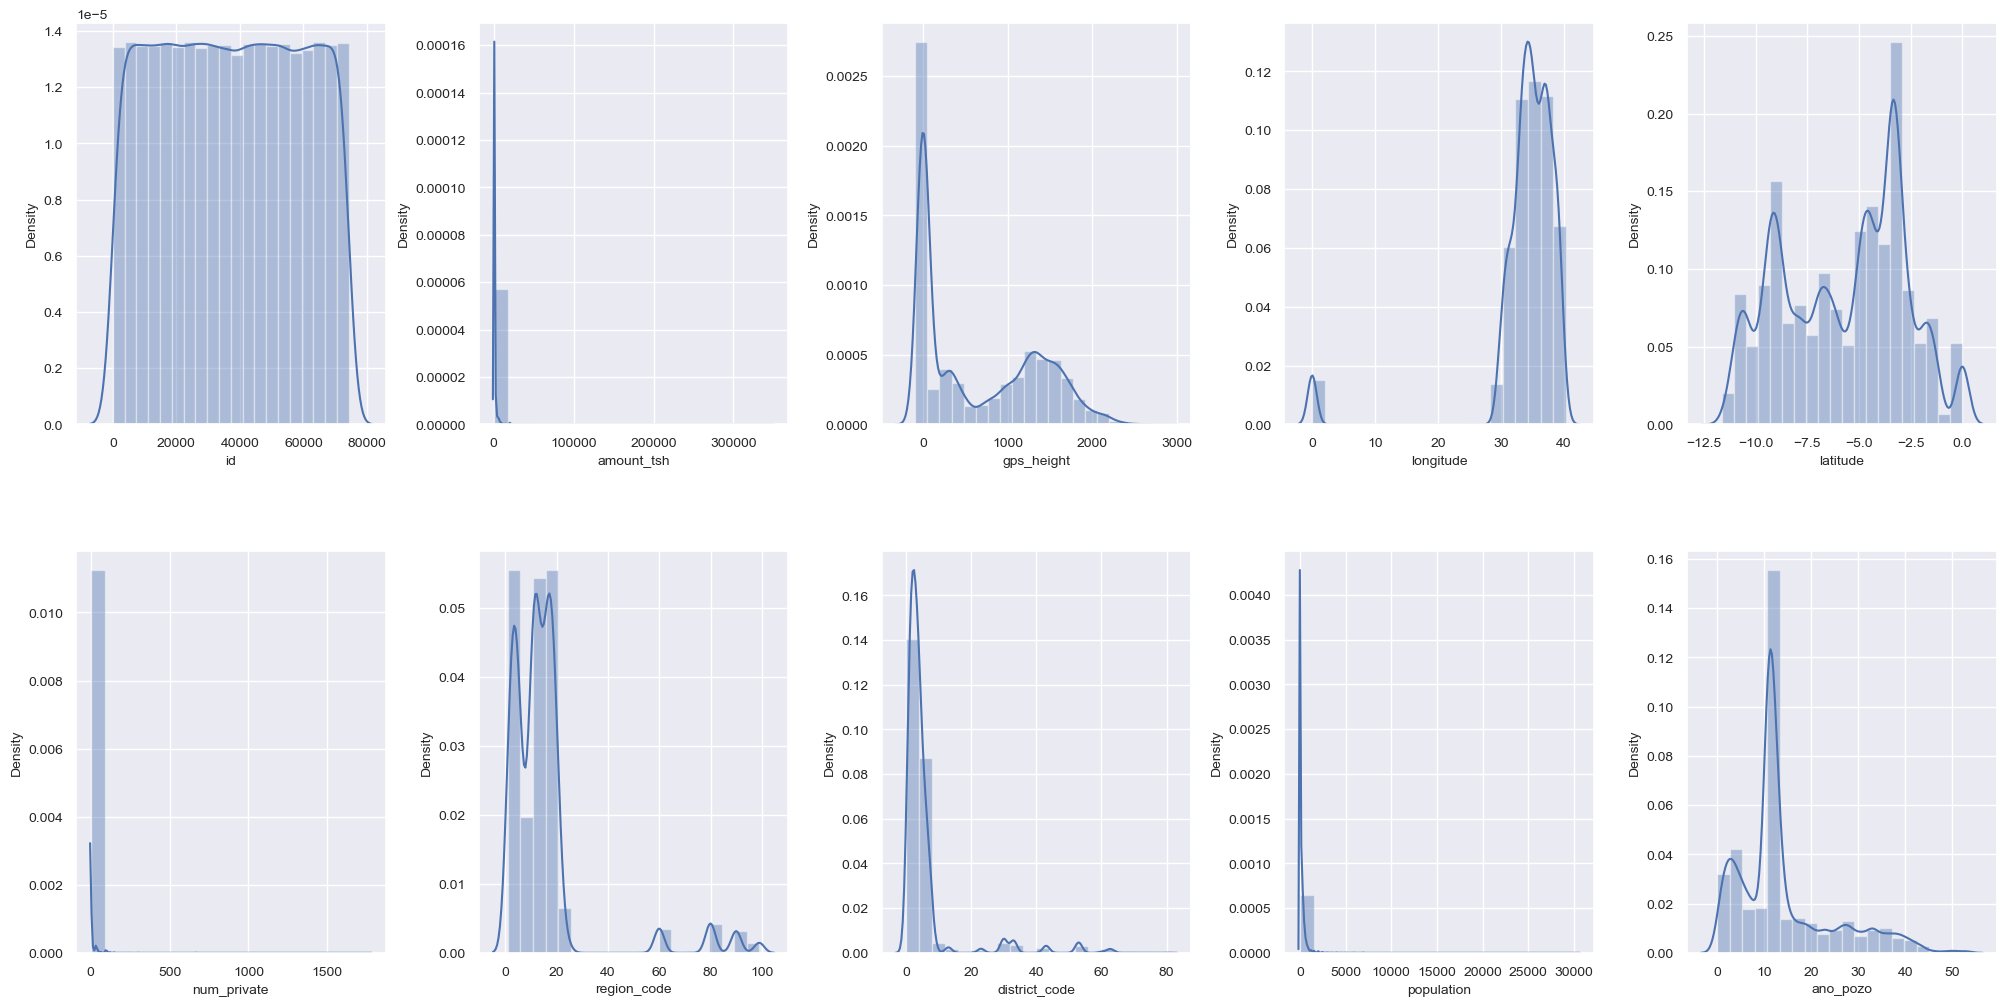

In [32]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
axs = axs.flatten() # 

index = 0
for k,v in full_df[new_num_cols].items(): 
    if  (k == 'permanencia'):
        sns.countplot(v, ax=axs[index])
    else:
        sns.distplot(v, bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Transformación variables a numéricas

In [33]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,K,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,K,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,11.0


In [34]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 59400 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              59400 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59400 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

In [35]:
full_df[new_cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,12721,21057,3565,10248,879,5294,2503,307,54345,59400,40671,29492,41908,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


Ahora voy a proceder a transformar estas variables a numéricas. Las variables con menos de 22 valores unicos voy a proceder a hacerlo manuel y asi tener más control propio en estos replace(). Las variables que tiene mas de 22 valores únicos voy a utilizar el LabelEncoder().

Nota: Pudiera proceder a realizar a traves de un bucle for para hacerlo más automático, pero quiero tener un poco el control de lo que estoy haciendo manualmente.

In [37]:
full_df['waterpoint_type_group'].sort_values().unique()

array(['cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [38]:
full_df.waterpoint_type_group.replace(('cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'), (1,2,3,4,5,6), inplace = True)

In [39]:
full_df['waterpoint_type'].sort_values().unique()

array(['cattle trough', 'communal standpipe',
       'communal standpipe multiple', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [40]:
full_df.waterpoint_type.replace(('cattle trough', 'communal standpipe', 'communal standpipe multiple', 'dam', 'hand pump',
       'improved spring', 'other'), (1,2,3,4,5,6,7), inplace = True)

Voy a proceder a pasar a dummies la variable source_class, ya que solo posee 3 valores diferentes.

In [41]:
full_df['source_class'].sort_values().unique()

array(['groundwater', 'surface', 'unknown'], dtype=object)

In [42]:
dummies = pd.get_dummies(full_df['source_class'], prefix='source_class')

In [43]:
full_df = pd.concat([full_df, dummies], axis=1)

In [44]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,2,2,functional,12.0,True,False,False
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,K,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,2,2,functional,3.0,False,True,False
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,3,2,functional,4.0,False,True,False
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,K,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,3,2,non functional,27.0,True,False,False
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,2,2,functional,11.0,False,True,False


In [45]:
full_df['source_class_groundwater'] = full_df['source_class_groundwater'].astype(int)

In [46]:
full_df['source_class_surface'] = full_df['source_class_surface'].astype(int)

In [47]:
full_df['source_class_unknown'] = full_df['source_class_unknown'].astype(int)

In [48]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,2,2,functional,12.0,1,0,0
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,K,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,2,2,functional,3.0,0,1,0
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,3,2,functional,4.0,0,1,0
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,K,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,3,2,non functional,27.0,1,0,0
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,2,2,functional,11.0,0,1,0


Aqui pase las variables dummies que se habian pasado en true y false, las pase a numericas.

In [49]:
full_df['source_type'].sort_values().unique()

array(['borehole', 'dam', 'other', 'rainwater harvesting', 'river/lake',
       'shallow well', 'spring'], dtype=object)

In [50]:
full_df.source_type.replace(('borehole', 'dam', 'other', 'rainwater harvesting', 'river/lake',
       'shallow well', 'spring'), (1,2,3,4,5,6,7), inplace = True)

In [51]:
full_df['source'].sort_values().unique()

array(['dam', 'hand dtw', 'lake', 'machine dbh', 'other',
       'rainwater harvesting', 'river', 'shallow well', 'spring',
       'unknown'], dtype=object)

In [52]:
full_df.source.replace(('dam', 'hand dtw', 'lake', 'machine dbh', 'other',
       'rainwater harvesting', 'river', 'shallow well', 'spring',
       'unknown'), (1,2,3,4,5,6,7,8,9,10), inplace = True)

In [53]:
full_df['quantity_group'].sort_values().unique()

array(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'],
      dtype=object)

In [54]:
full_df.quantity_group.replace(('dry', 'enough', 'insufficient', 'seasonal', 'unknown'), (1,2,3,4,5), inplace = True)

In [55]:
full_df['quantity'].sort_values().unique()

array(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'],
      dtype=object)

In [56]:
full_df.quantity.replace(('dry', 'enough', 'insufficient', 'seasonal', 'unknown'), (1,2,3,4,5), inplace = True)

Haciendo este cambio manual me estoy dando cuenta que tal vez haya la repetición de valores de variables, 'quantity_group' y 'quantity' poseen los mismos valores, y en el .head() arriba muestra que cada fila repite el mismo valor para quantity_group y quantity, por lo que seria redundante y tal vez sea mejor hacerle .drop() a alguna de las dos, pero primero antes de hacerlo evaluare la correlación de todas las variables.

In [57]:
full_df['quality_group'].sort_values().unique()

array(['colored', 'fluoride', 'good', 'milky', 'salty', 'unknown'],
      dtype=object)

In [58]:
full_df['quality_group'].value_counts()

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: count, dtype: int64

In [59]:
full_df.quality_group.replace(('colored', 'fluoride', 'good', 'milky', 'salty', 'unknown'), (1,2,3,4,5,6), inplace = True)

In [60]:
full_df['water_quality'].sort_values().unique()

array(['coloured', 'fluoride', 'fluoride abandoned', 'milky', 'salty',
       'salty abandoned', 'soft', 'unknown'], dtype=object)

In [61]:
full_df.water_quality.replace(('coloured', 'fluoride', 'fluoride abandoned', 'milky', 'salty',
       'salty abandoned', 'soft', 'unknown'), (1,2,3,4,5,6,7,8), inplace = True)

In [62]:
full_df['payment_type'].sort_values().unique()

array(['annually', 'monthly', 'never pay', 'on failure', 'other',
       'per bucket', 'unknown'], dtype=object)

In [63]:
full_df.payment_type.replace(('annually', 'monthly', 'never pay', 'on failure', 'other',
       'per bucket', 'unknown'), (1,2,3,4,5,6,7), inplace = True)

In [64]:
full_df['payment'].sort_values().unique()

array(['never pay', 'other', 'pay annually', 'pay monthly',
       'pay per bucket', 'pay when scheme fails', 'unknown'], dtype=object)

In [65]:
full_df.payment.replace(('never pay', 'other', 'pay annually', 'pay monthly',
       'pay per bucket', 'pay when scheme fails', 'unknown'), (1,2,3,4,5,6,7), inplace = True)

In [66]:
full_df['management_group'].sort_values().unique()

array(['commercial', 'other', 'parastatal', 'unknown', 'user-group'],
      dtype=object)

In [67]:
full_df.management_group.replace(('commercial', 'other', 'parastatal', 'unknown', 'user-group'), (1,2,3,4,5), inplace = True)

In [68]:
full_df['management'].sort_values().unique()

array(['company', 'other', 'other - school', 'parastatal',
       'private operator', 'trust', 'unknown', 'vwc', 'water authority',
       'water board', 'wua', 'wug'], dtype=object)

In [69]:
full_df.management.replace(('company', 'other', 'other - school', 'parastatal',
       'private operator', 'trust', 'unknown', 'vwc', 'water authority',
       'water board', 'wua', 'wug'), (1,2,3,4,5,6,7,8,9,10,11,12), inplace = True)

In [70]:
full_df['extraction_type_class'].sort_values().unique()

array(['gravity', 'handpump', 'motorpump', 'other', 'rope pump',
       'submersible', 'wind-powered'], dtype=object)

In [71]:
full_df.extraction_type_class.replace(('gravity', 'handpump', 'motorpump', 'other', 'rope pump',
       'submersible', 'wind-powered'), (1,2,3,4,5,6,7), inplace = True)

In [72]:
full_df['extraction_type_group'].sort_values().unique()

array(['afridev', 'gravity', 'india mark ii', 'india mark iii', 'mono',
       'nira/tanira', 'other', 'other handpump', 'other motorpump',
       'rope pump', 'submersible', 'swn 80', 'wind-powered'], dtype=object)

In [73]:
full_df.extraction_type_group.replace(('afridev', 'gravity', 'india mark ii', 'india mark iii', 'mono',
       'nira/tanira', 'other', 'other handpump', 'other motorpump',
       'rope pump', 'submersible', 'swn 80', 'wind-powered'), (1,2,3,4,5,6,7,8,9,10,11,12,13), inplace = True)

In [74]:
full_df['extraction_type'].sort_values().unique()

array(['afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other',
       'other - mkulima/shinyanga', 'other - play pump',
       'other - rope pump', 'other - swn 81', 'submersible', 'swn 80',
       'walimi', 'windmill'], dtype=object)

In [75]:
full_df.extraction_type.replace(('afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other',
       'other - mkulima/shinyanga', 'other - play pump',
       'other - rope pump', 'other - swn 81', 'submersible', 'swn 80',
       'walimi', 'windmill'), (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18), inplace = True)

In [76]:
full_df['scheme_management'].sort_values().unique()

array(['Company', 'Other', 'Parastatal', 'Private operator', 'SWC',
       'Trust', 'VWC', 'WUA', 'WUG', 'Water Board', 'Water authority'],
      dtype=object)

In [77]:
full_df.scheme_management.replace(('Company', 'Other', 'Parastatal', 'Private operator', 'SWC',
       'Trust', 'VWC', 'WUA', 'WUG', 'Water Board', 'Water authority'), (1,2,3,4,5,6,7,8,9,10,11), inplace = True)

In [78]:
full_df['region'].sort_values().unique()

array(['Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kagera', 'Kigoma',
       'Kilimanjaro', 'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro',
       'Mtwara', 'Mwanza', 'Pwani', 'Rukwa', 'Ruvuma', 'Shinyanga',
       'Singida', 'Tabora', 'Tanga'], dtype=object)

In [79]:
full_df.region.replace(('Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kagera', 'Kigoma',
       'Kilimanjaro', 'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro',
       'Mtwara', 'Mwanza', 'Pwani', 'Rukwa', 'Ruvuma', 'Shinyanga',
       'Singida', 'Tabora', 'Tanga'), (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21), inplace = True)

In [80]:
full_df['basin'].sort_values().unique()

array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu'], dtype=object)

In [81]:
full_df.basin.replace(('Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu'), (1,2,3,4,5,6,7,8,9), inplace = True)

He terminado la transformacion de variables manual, ahora voy a proceder a los que tienen muchos valores unicos y las transformare a traves del LabelEncoder() anteriormente dicho.

Defino el Label Encoder()

In [82]:
le = LabelEncoder()

In [83]:
full_df['scheme_name'] = le.fit_transform(full_df['scheme_name'])

In [84]:
full_df['ward'] = le.fit_transform(full_df['ward'])

In [85]:
full_df['lga'] = le.fit_transform(full_df['lga'])

In [86]:
full_df['subvillage'] = le.fit_transform(full_df['subvillage'])

In [87]:
full_df['wpt_name'] = le.fit_transform(full_df['wpt_name'])

In [88]:
full_df['installer'] = le.fit_transform(full_df['installer'])

In [89]:
full_df['funder'] = le.fit_transform(full_df['funder'])

Voy hacer a mostrar como esta el dataframe para ver que tal va la transformacion a númericas

In [90]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,True,GeoData Consultants Ltd,7,2244,False,4,2,1,8,5,3,1,7,3,2,2,9,7,groundwater,2,2,functional,12.0,1,0,0
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,True,GeoData Consultants Ltd,2,598,True,4,2,1,12,5,1,3,7,3,3,3,6,4,surface,2,2,functional,3.0,0,1,0
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,True,GeoData Consultants Ltd,7,2120,True,4,2,1,8,5,5,6,7,3,2,2,1,2,surface,3,2,functional,4.0,0,1,0
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,True,GeoData Consultants Ltd,7,598,True,15,11,6,8,5,1,3,7,3,1,1,4,1,groundwater,3,2,non functional,27.0,1,0,0
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,True,GeoData Consultants Ltd,7,598,True,4,2,1,2,2,1,3,7,3,4,4,6,4,surface,2,2,functional,11.0,0,1,0


Me falta hacerle .drop() a las variables recorded_by y a source_class que ya la habia convertido a dummies, pero primero pasare a dummies public_permit y permit.

In [91]:
dummies1 = pd.get_dummies(full_df['public_meeting'], prefix='public_meeting', drop_first=False)

In [92]:
full_df = pd.concat([full_df, dummies1], axis=1)

In [93]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,True,GeoData Consultants Ltd,7,2244,False,4,2,1,8,5,3,1,7,3,2,2,9,7,groundwater,2,2,functional,12.0,1,0,0,False,True
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,True,GeoData Consultants Ltd,2,598,True,4,2,1,12,5,1,3,7,3,3,3,6,4,surface,2,2,functional,3.0,0,1,0,False,True
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,True,GeoData Consultants Ltd,7,2120,True,4,2,1,8,5,5,6,7,3,2,2,1,2,surface,3,2,functional,4.0,0,1,0,False,True
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,True,GeoData Consultants Ltd,7,598,True,15,11,6,8,5,1,3,7,3,1,1,4,1,groundwater,3,2,non functional,27.0,1,0,0,False,True
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,True,GeoData Consultants Ltd,7,598,True,4,2,1,2,2,1,3,7,3,4,4,6,4,surface,2,2,functional,11.0,0,1,0,False,True


In [94]:
full_df['public_meeting_False'] = full_df['public_meeting_False'].astype(int)

In [95]:
full_df['public_meeting_True'] = full_df['public_meeting_True'].astype(int)

In [96]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,True,GeoData Consultants Ltd,7,2244,False,4,2,1,8,5,3,1,7,3,2,2,9,7,groundwater,2,2,functional,12.0,1,0,0,0,1
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,True,GeoData Consultants Ltd,2,598,True,4,2,1,12,5,1,3,7,3,3,3,6,4,surface,2,2,functional,3.0,0,1,0,0,1
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,True,GeoData Consultants Ltd,7,2120,True,4,2,1,8,5,5,6,7,3,2,2,1,2,surface,3,2,functional,4.0,0,1,0,0,1
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,True,GeoData Consultants Ltd,7,598,True,15,11,6,8,5,1,3,7,3,1,1,4,1,groundwater,3,2,non functional,27.0,1,0,0,0,1
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,True,GeoData Consultants Ltd,7,598,True,4,2,1,2,2,1,3,7,3,4,4,6,4,surface,2,2,functional,11.0,0,1,0,0,1


In [97]:
dummies2 = pd.get_dummies(full_df['permit'], prefix='permit', drop_first=False)

In [98]:
full_df = pd.concat([full_df, dummies2], axis=1)

In [99]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,True,GeoData Consultants Ltd,7,2244,False,4,2,1,8,5,3,1,7,3,2,2,9,7,groundwater,2,2,functional,12.0,1,0,0,0,1,True,False
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,True,GeoData Consultants Ltd,2,598,True,4,2,1,12,5,1,3,7,3,3,3,6,4,surface,2,2,functional,3.0,0,1,0,0,1,False,True
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,True,GeoData Consultants Ltd,7,2120,True,4,2,1,8,5,5,6,7,3,2,2,1,2,surface,3,2,functional,4.0,0,1,0,0,1,False,True
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,True,GeoData Consultants Ltd,7,598,True,15,11,6,8,5,1,3,7,3,1,1,4,1,groundwater,3,2,non functional,27.0,1,0,0,0,1,False,True
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,True,GeoData Consultants Ltd,7,598,True,4,2,1,2,2,1,3,7,3,4,4,6,4,surface,2,2,functional,11.0,0,1,0,0,1,False,True


In [100]:
full_df['permit_False'] = full_df['permit_False'].astype(int)

In [101]:
full_df['permit_True'] = full_df['permit_True'].astype(int)

In [102]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,True,GeoData Consultants Ltd,7,2244,False,4,2,1,8,5,3,1,7,3,2,2,9,7,groundwater,2,2,functional,12.0,1,0,0,0,1,1,0
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,True,GeoData Consultants Ltd,2,598,True,4,2,1,12,5,1,3,7,3,3,3,6,4,surface,2,2,functional,3.0,0,1,0,0,1,0,1
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,True,GeoData Consultants Ltd,7,2120,True,4,2,1,8,5,5,6,7,3,2,2,1,2,surface,3,2,functional,4.0,0,1,0,0,1,0,1
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,True,GeoData Consultants Ltd,7,598,True,15,11,6,8,5,1,3,7,3,1,1,4,1,groundwater,3,2,non functional,27.0,1,0,0,0,1,0,1
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,True,GeoData Consultants Ltd,7,598,True,4,2,1,2,2,1,3,7,3,4,4,6,4,surface,2,2,functional,11.0,0,1,0,0,1,0,1


In [103]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        59400 non-null  int64  
 1   amount_tsh                59400 non-null  float64
 2   funder                    59400 non-null  int32  
 3   gps_height                59400 non-null  int64  
 4   installer                 59400 non-null  int32  
 5   longitude                 59400 non-null  float64
 6   latitude                  59400 non-null  float64
 7   wpt_name                  59400 non-null  int32  
 8   num_private               59400 non-null  int64  
 9   basin                     59400 non-null  int64  
 10  subvillage                59400 non-null  int32  
 11  region                    59400 non-null  int64  
 12  region_code               59400 non-null  int64  
 13  district_code             59400 non-null  int64  
 14  lga   

In [104]:
full_df.drop(['source_class', 'recorded_by', 'quality_group', 'public_meeting', 'permit'], axis = 1, inplace = True)

In [105]:
full_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,scheme_name,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,status_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,37398,0,2,11807,4,11,5,51,1426,109,7,2244,4,2,1,8,5,3,1,7,2,2,9,7,2,2,functional,12.0,1,0,0,0,1,1,0
1,8776,0.0,469,1399,545,34.698766,-2.147466,37194,0,5,15838,10,20,2,103,1576,280,2,598,4,2,1,12,5,1,3,7,3,3,6,4,2,2,functional,3.0,0,1,0,0,1,0,1
2,34310,25.0,825,686,2048,37.460664,-3.821329,14572,0,6,9074,9,21,4,108,1624,250,7,2120,4,2,1,8,5,5,6,7,2,2,1,2,3,2,functional,4.0,0,1,0,0,1,0,1
3,67743,0.0,1740,263,1852,38.486161,-11.155298,37284,0,8,8982,13,90,63,87,1571,58,7,598,15,11,6,8,5,1,3,7,1,1,4,1,3,2,non functional,27.0,1,0,0,0,1,0,1
4,19728,0.0,20,0,119,31.130847,-1.825359,35528,0,5,7698,5,18,1,26,1687,0,7,598,4,2,1,2,2,1,3,7,4,4,6,4,2,2,functional,11.0,0,1,0,0,1,0,1


Ahora mi dataframe parece estar todo con valores numericos.

In [107]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        59400 non-null  int64  
 1   amount_tsh                59400 non-null  float64
 2   funder                    59400 non-null  int32  
 3   gps_height                59400 non-null  int64  
 4   installer                 59400 non-null  int32  
 5   longitude                 59400 non-null  float64
 6   latitude                  59400 non-null  float64
 7   wpt_name                  59400 non-null  int32  
 8   num_private               59400 non-null  int64  
 9   basin                     59400 non-null  int64  
 10  subvillage                59400 non-null  int32  
 11  region                    59400 non-null  int64  
 12  region_code               59400 non-null  int64  
 13  district_code             59400 non-null  int64  
 14  lga   

Ahora quiero evaluar la correlacion de las variables independientes con mi variable objetivo.

In [109]:
full_df['status_group'].sort_values().unique()

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [110]:
full_df.status_group.replace(('functional', 'functional needs repair', 'non functional'), (1,2,3), inplace = True)

In [111]:
corr = abs(full_df.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
ano_pozo,0.223334
waterpoint_type,0.206507
waterpoint_type_group,0.206431
extraction_type_class,0.175338
quantity_group,0.131425
quantity,0.131425
gps_height,0.114029
extraction_type_group,0.111497
region_code,0.108640


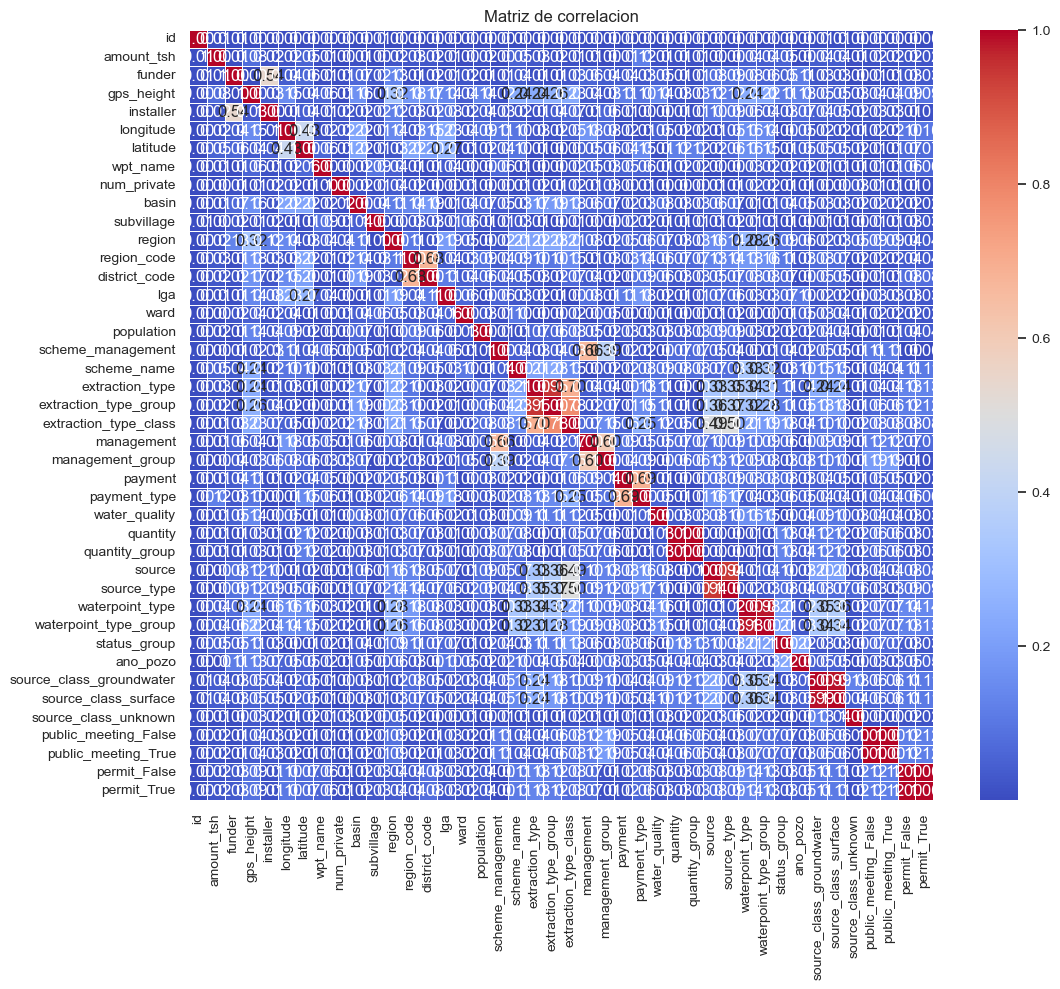

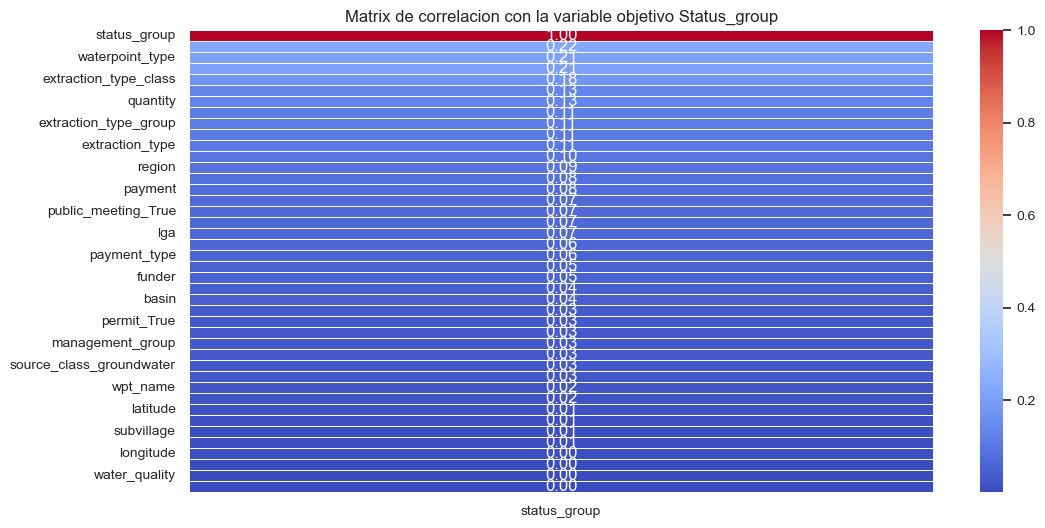

In [112]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Matriz de correlacion')
plt.show()

sorted_corr = corr.sort_values(by='status_group', ascending=False)
sorted_corr = sorted_corr.sort_index(axis=1, ascending=False)
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_corr[['status_group']], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Matrix de correlacion con la variable objetivo Status_group')
plt.show()

Hare un boxplot para cada una de las variables para evaluar los outliers

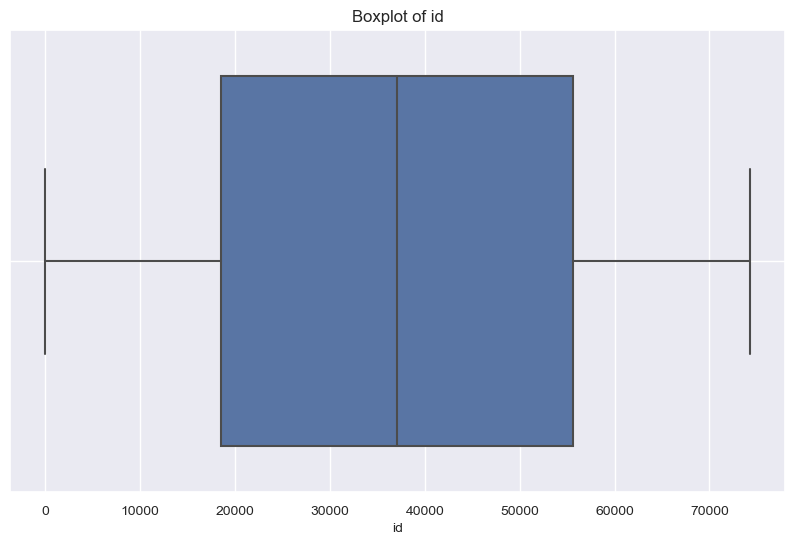

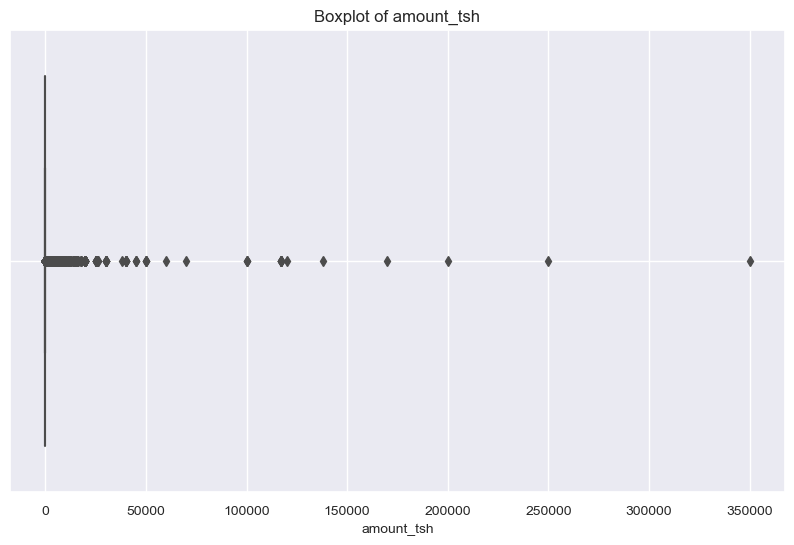

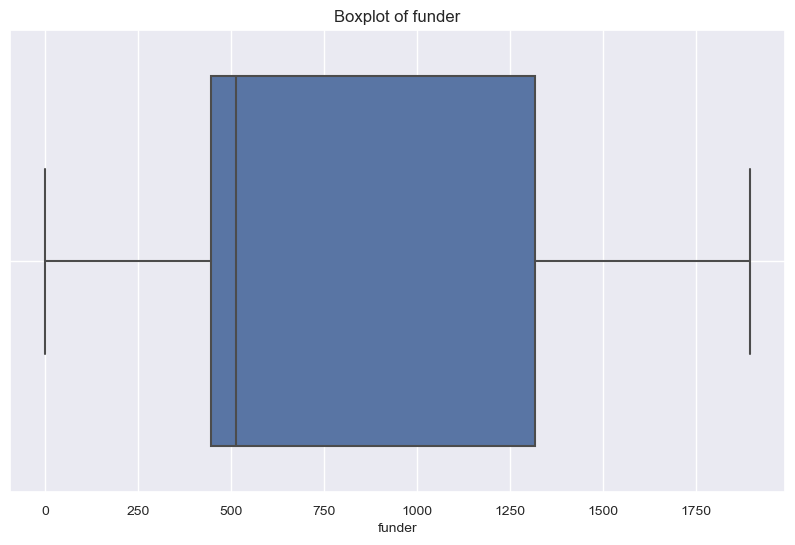

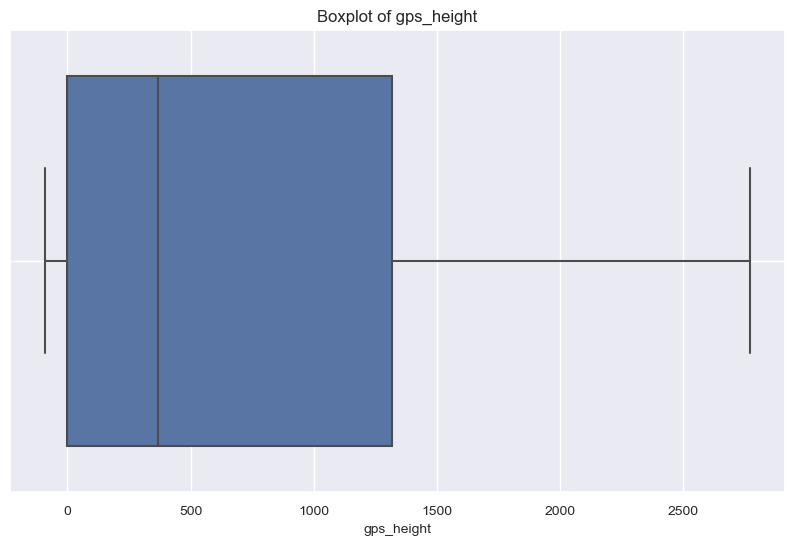

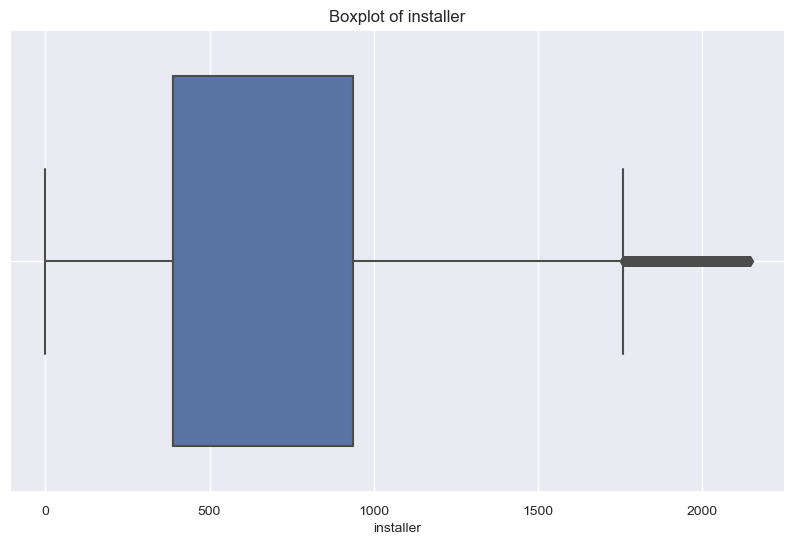

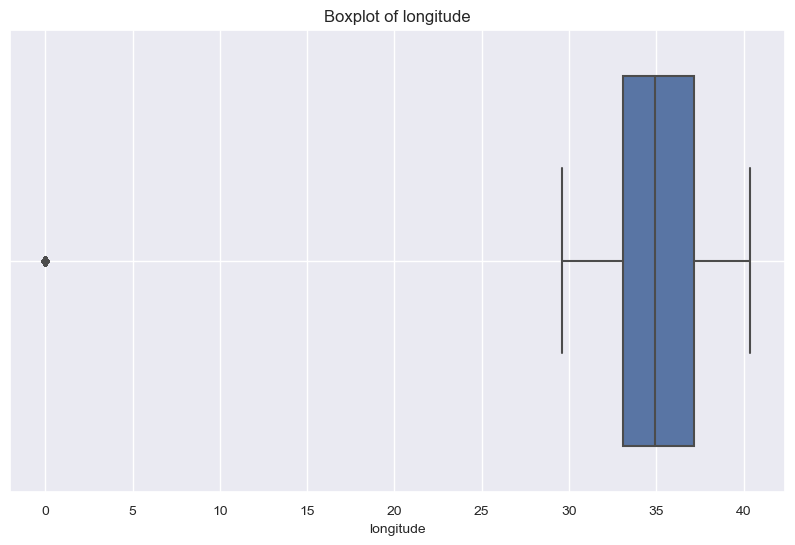

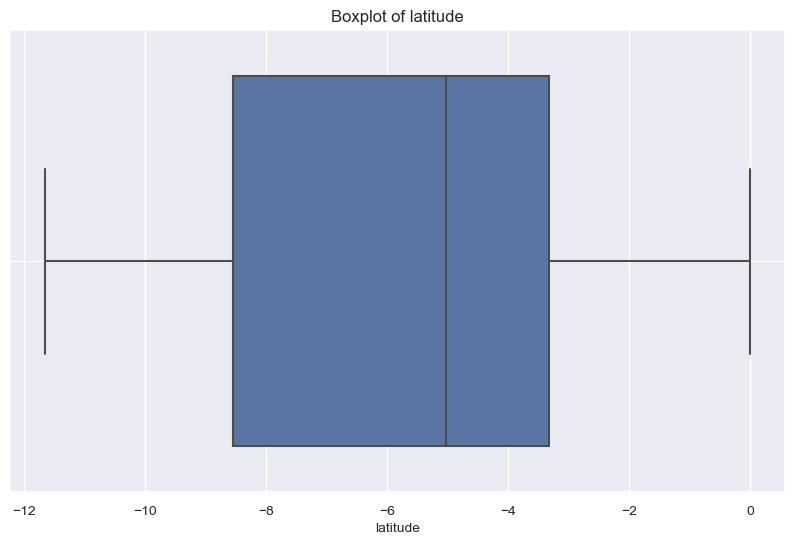

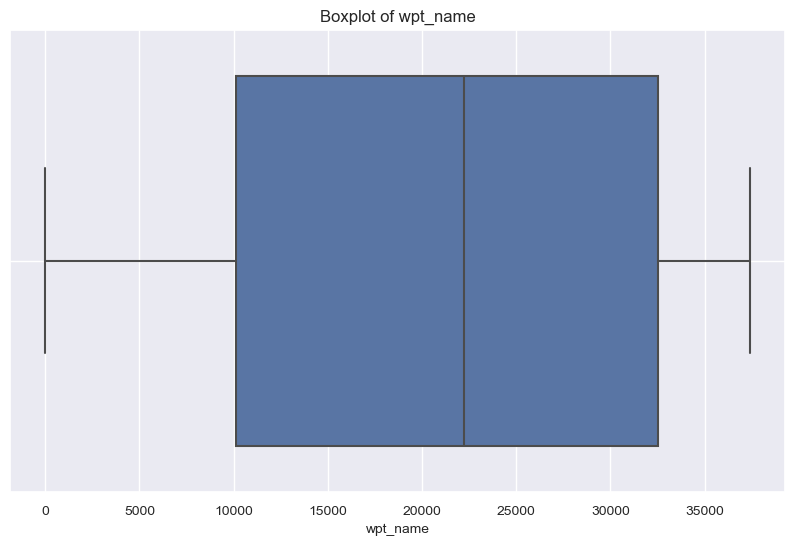

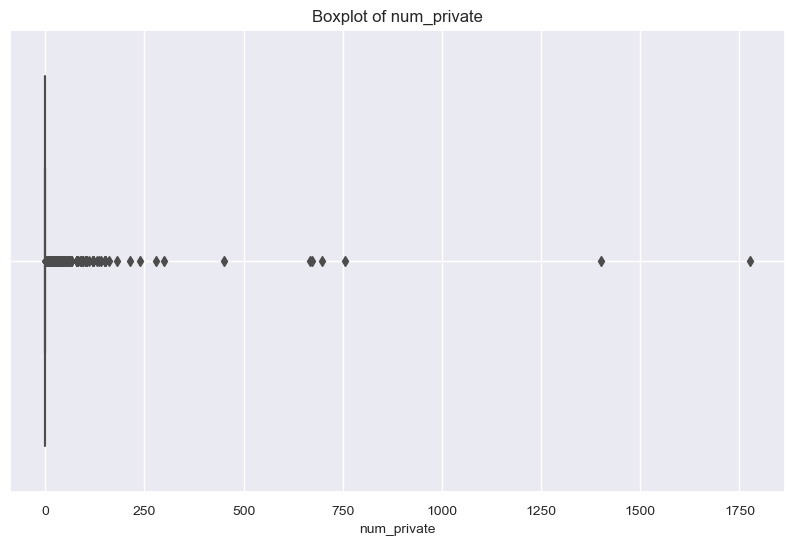

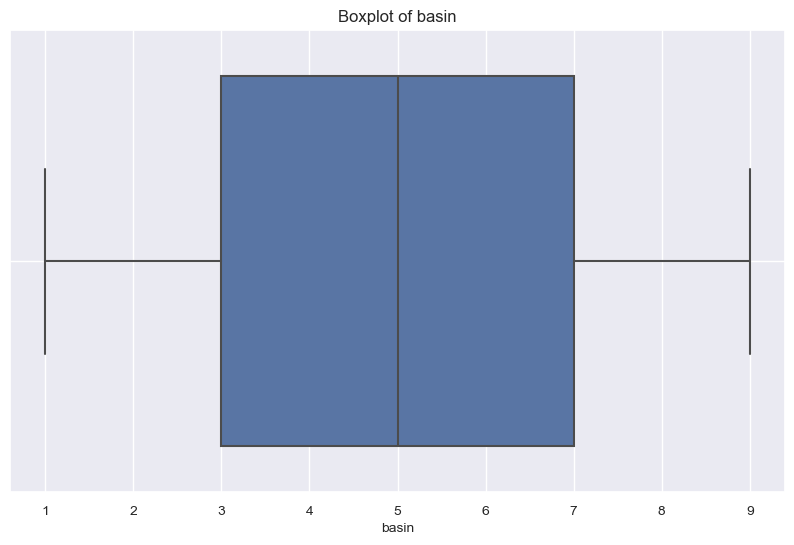

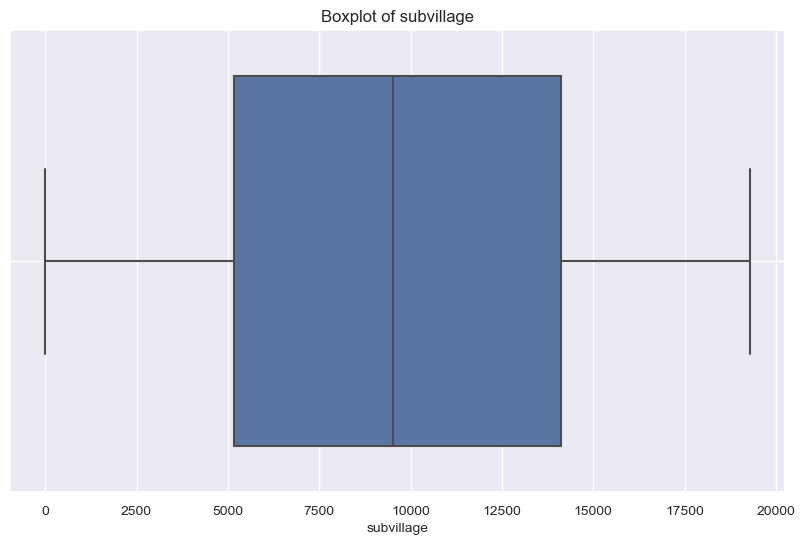

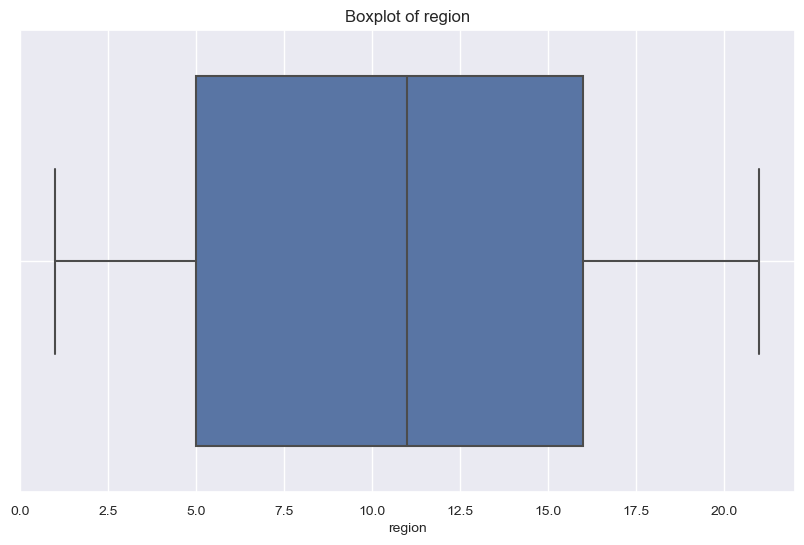

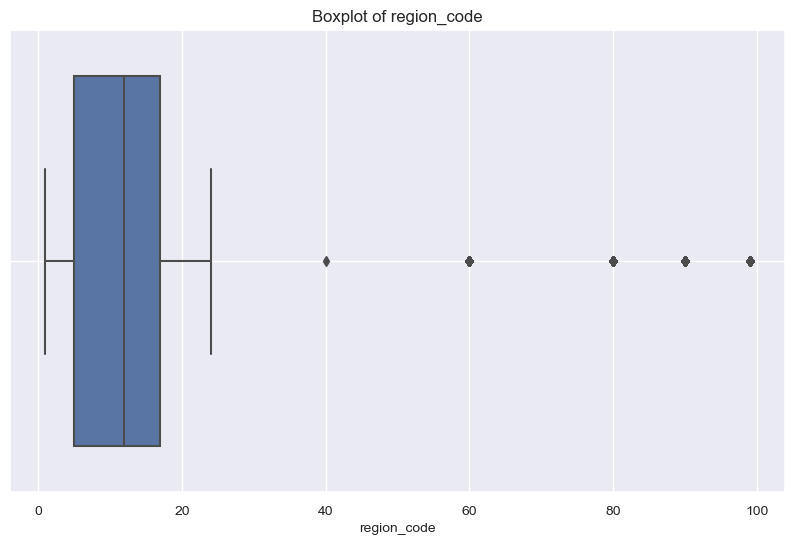

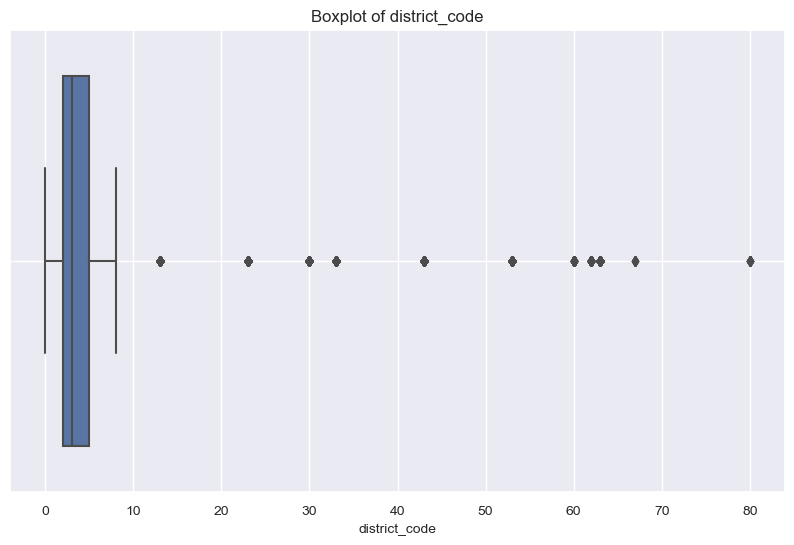

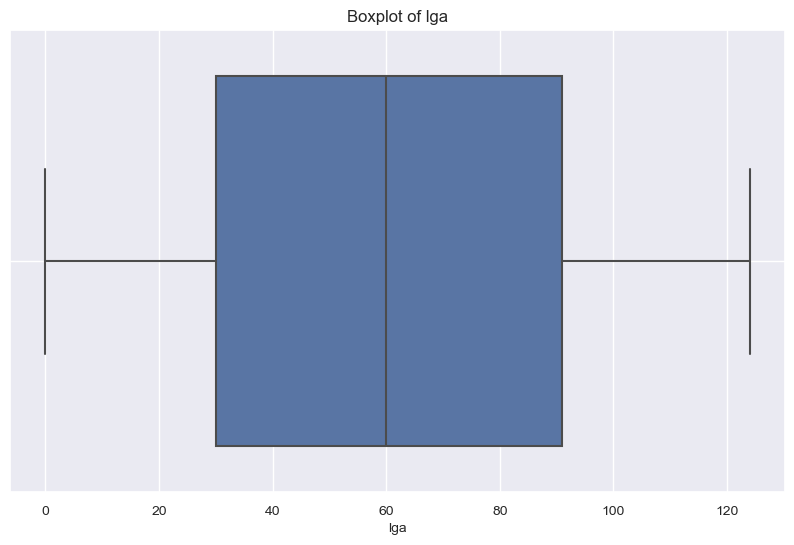

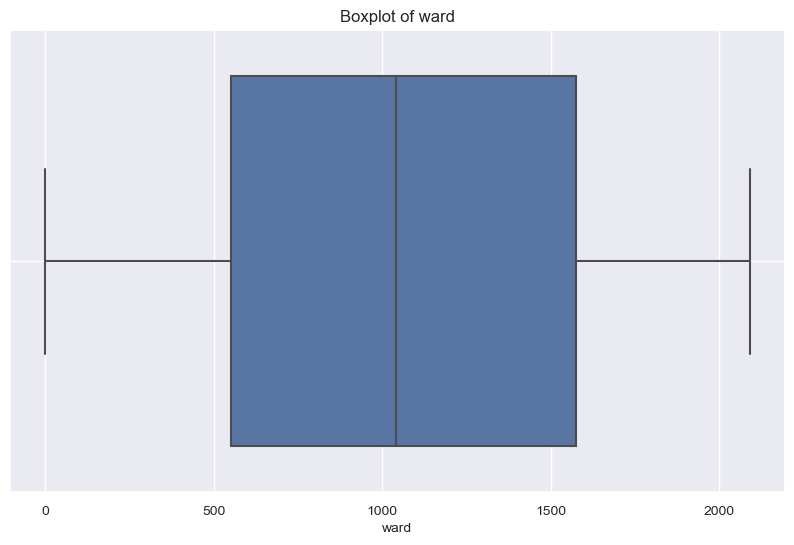

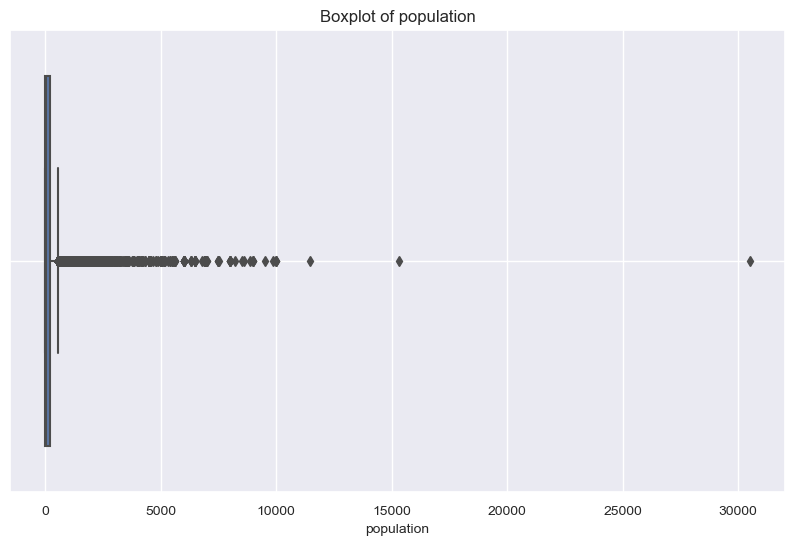

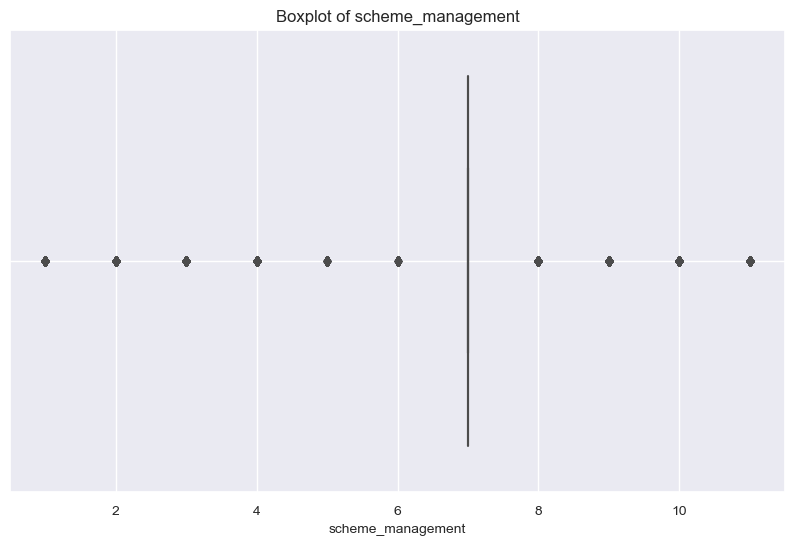

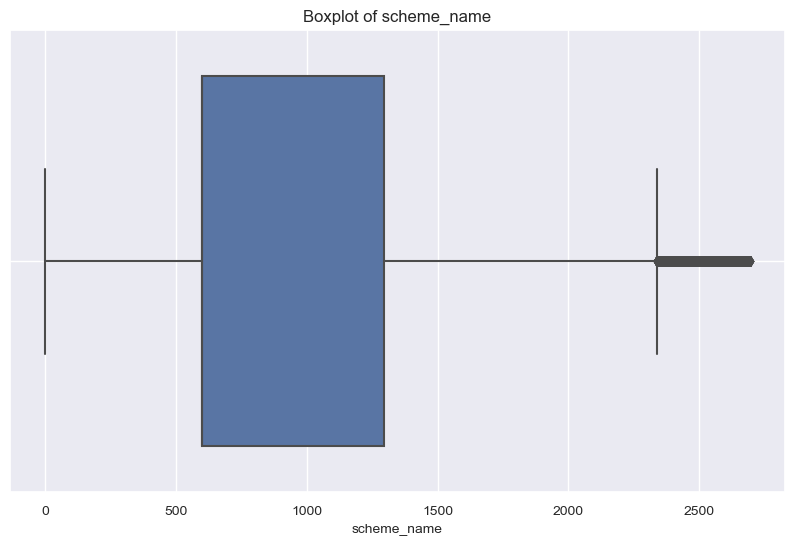

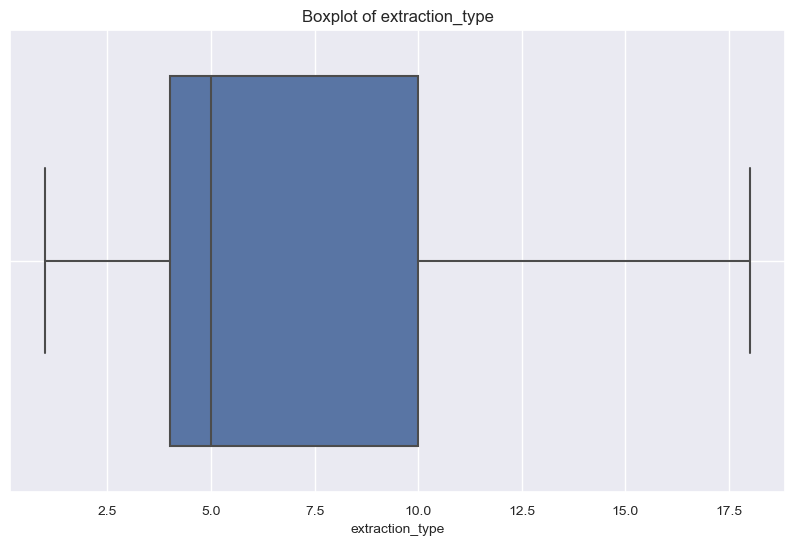

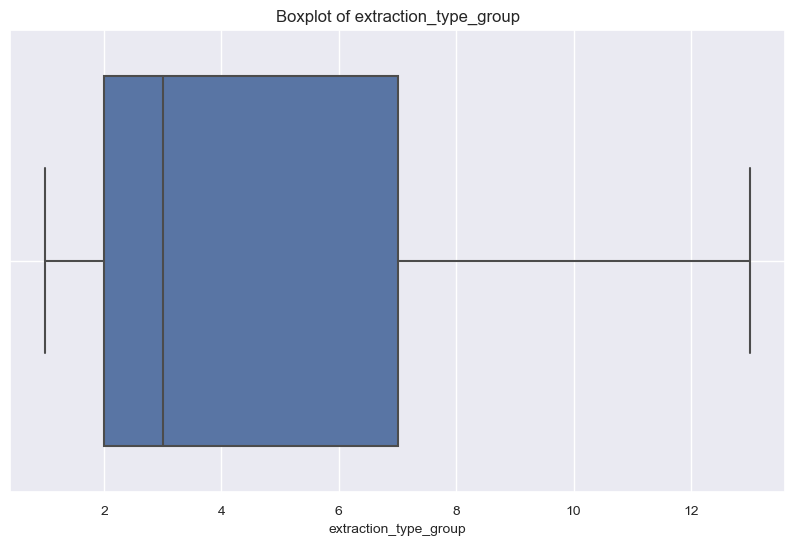

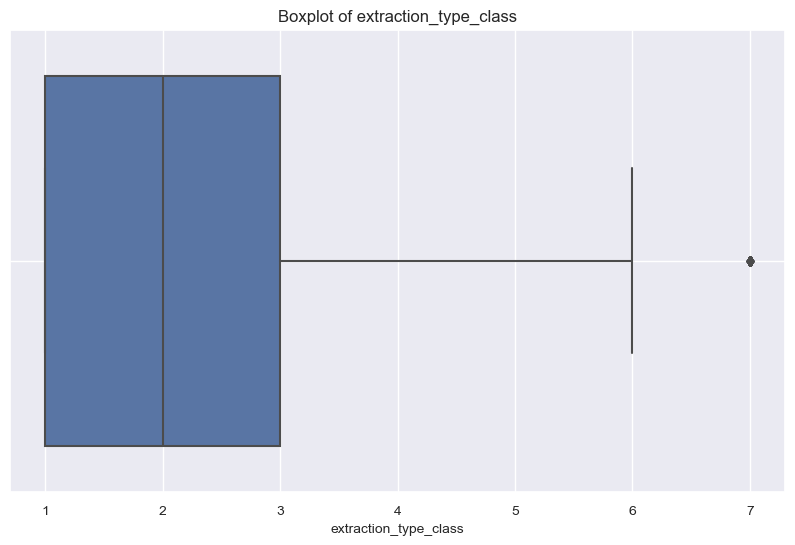

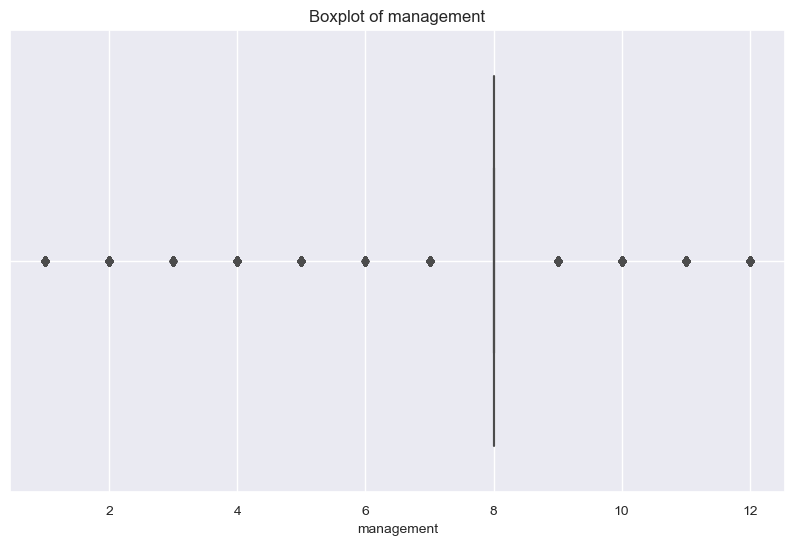

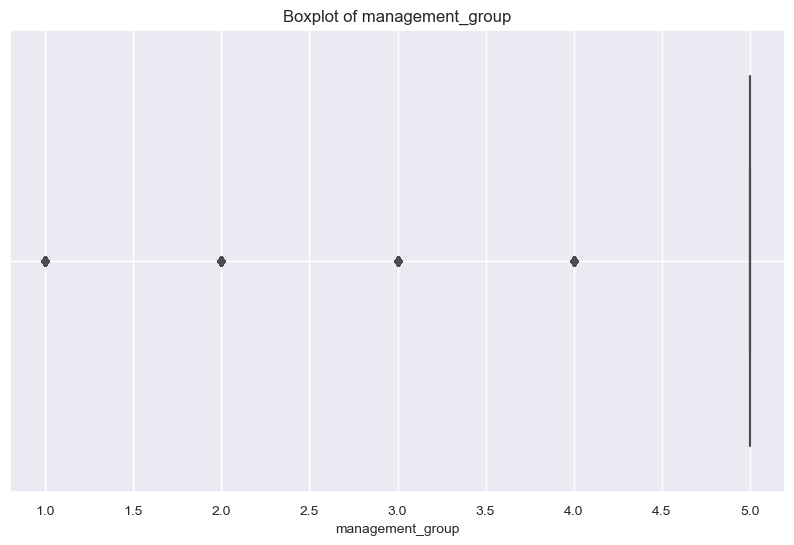

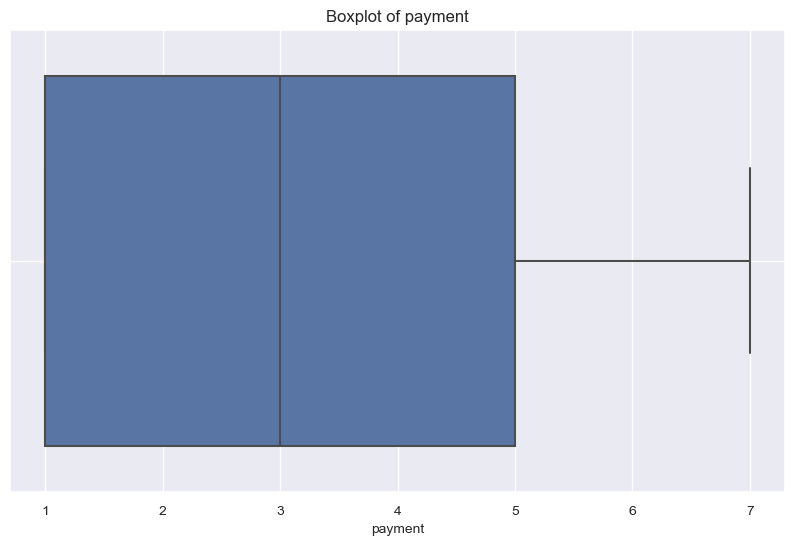

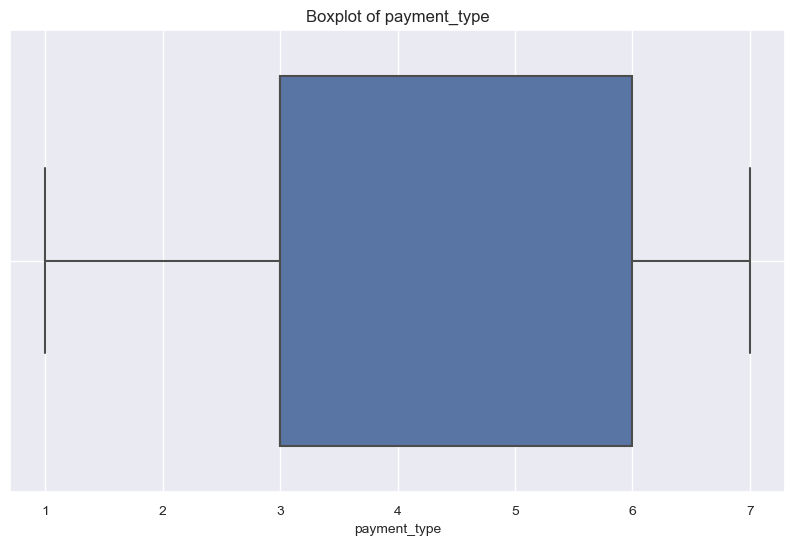

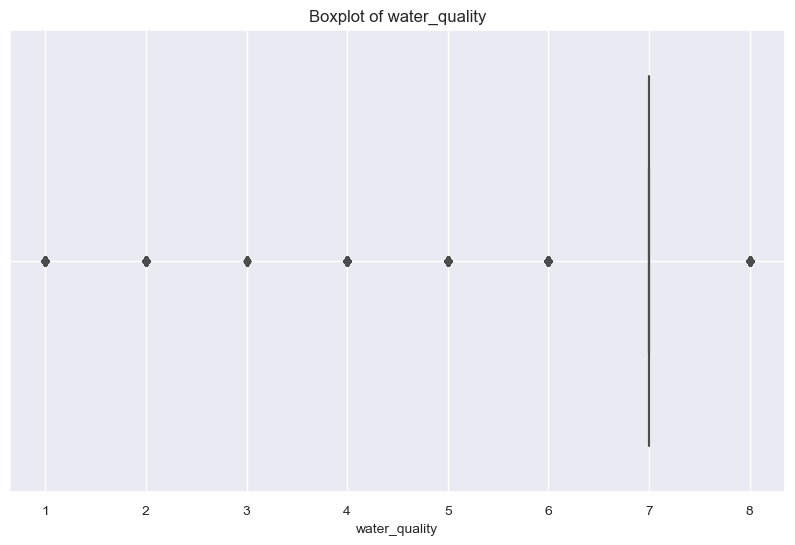

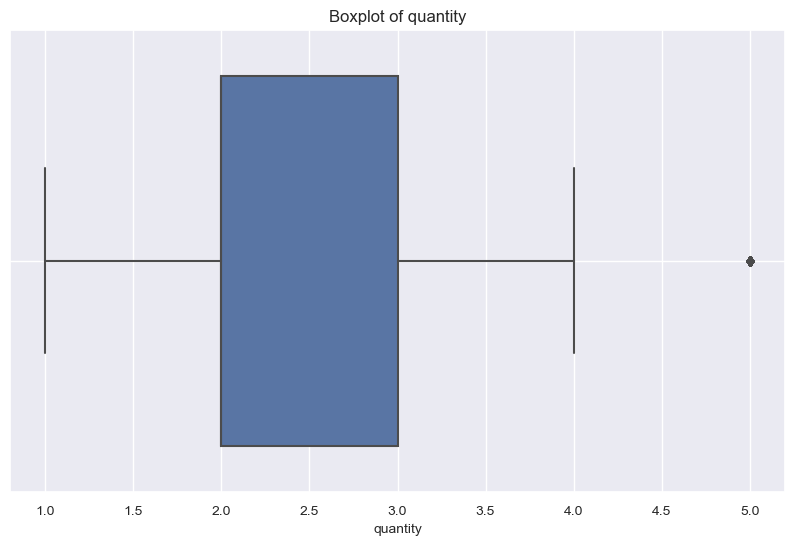

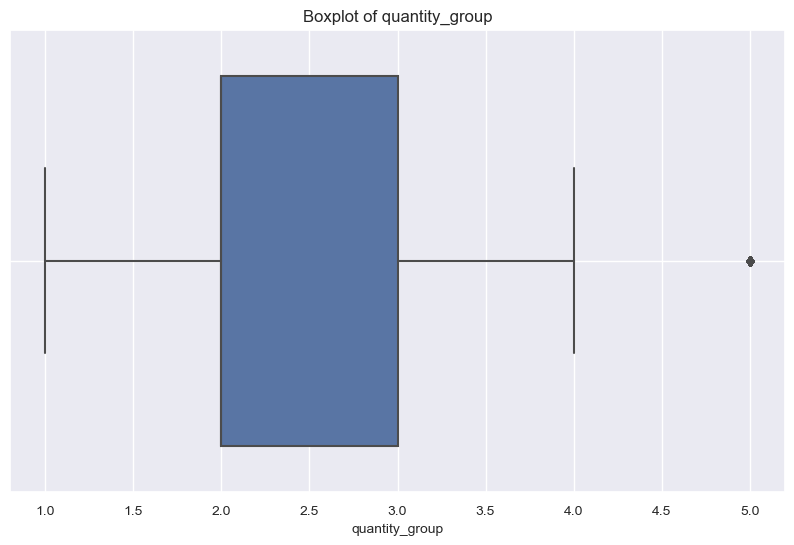

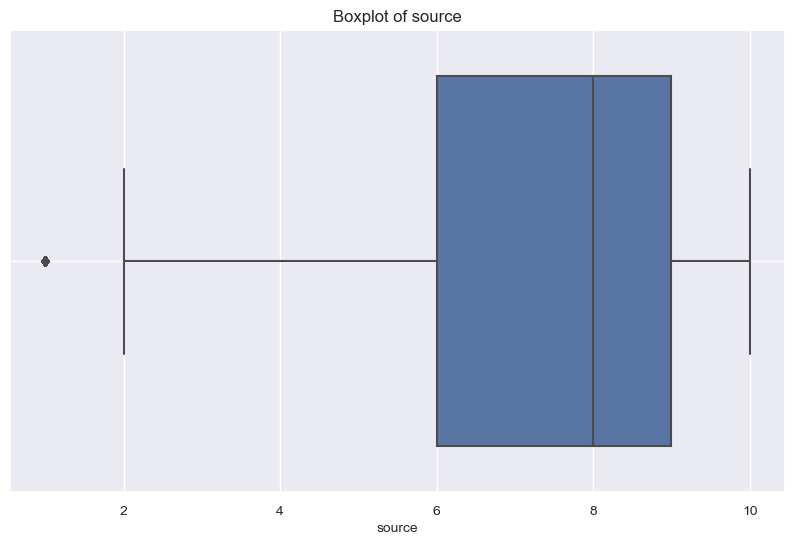

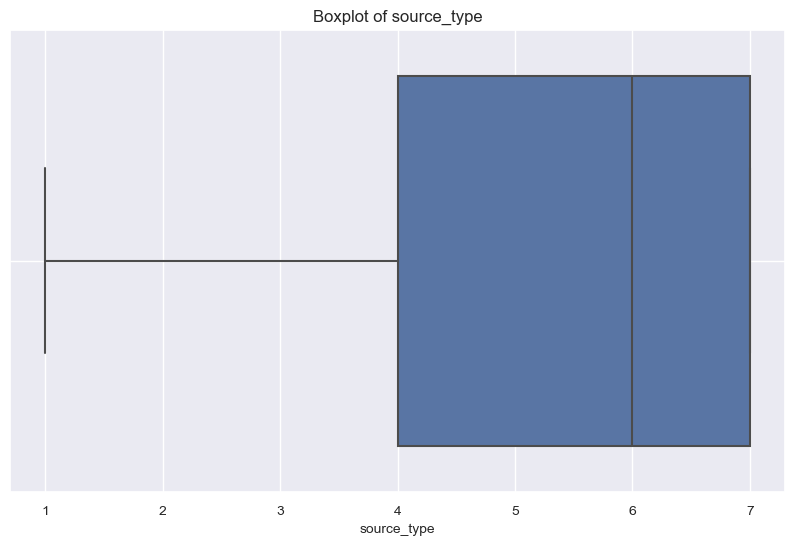

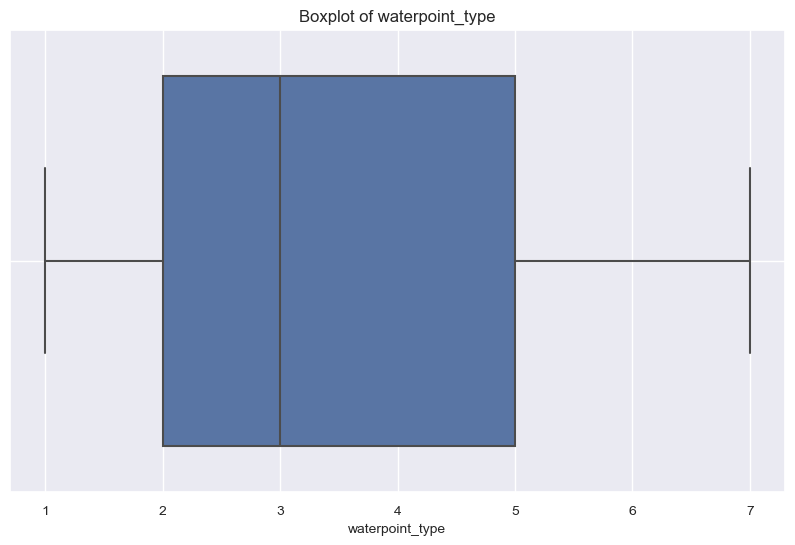

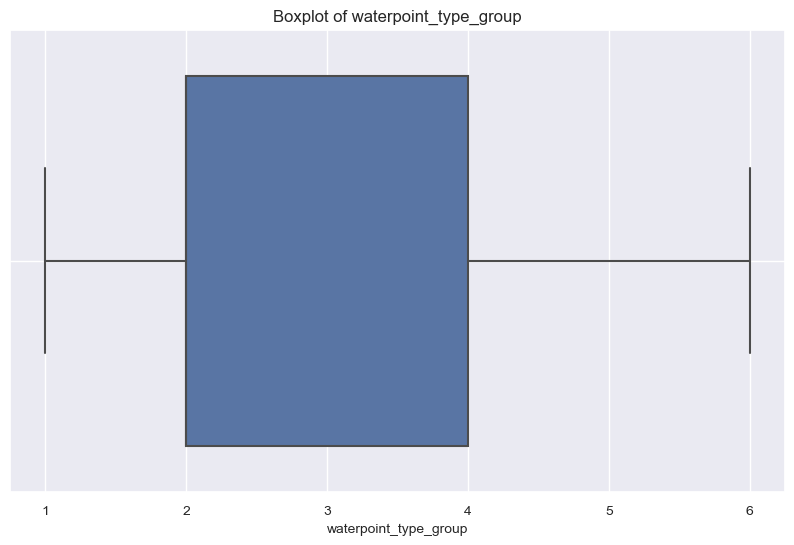

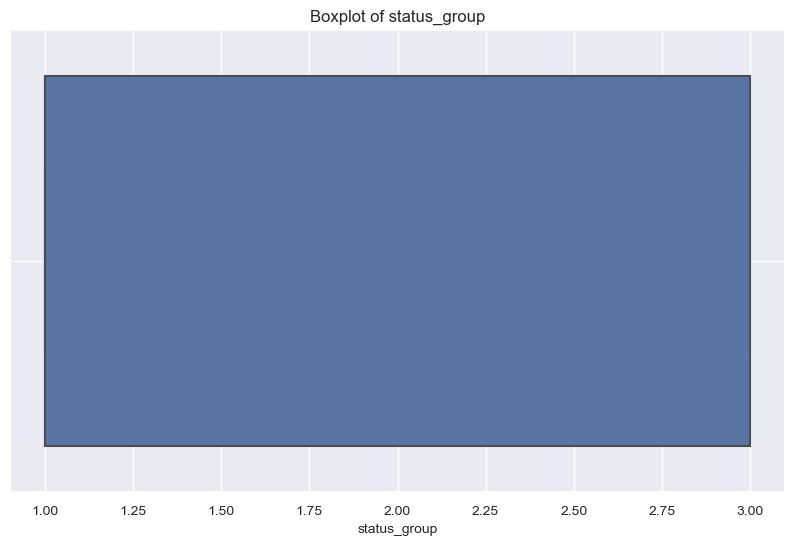

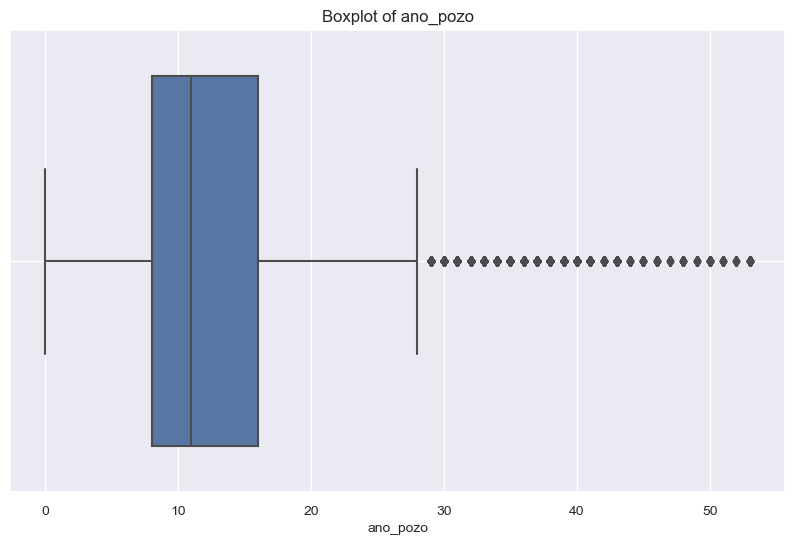

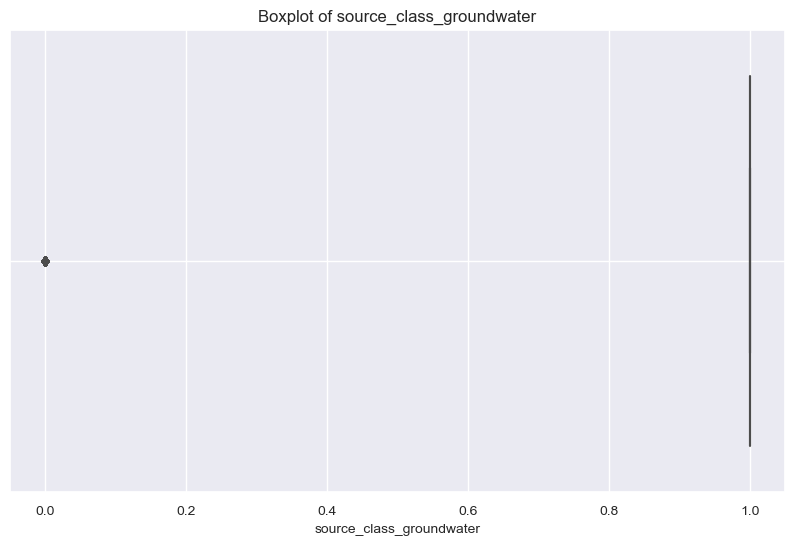

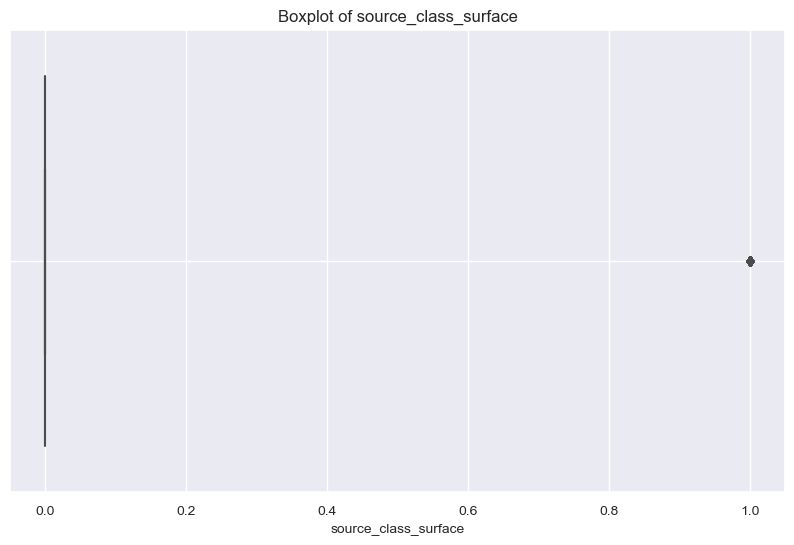

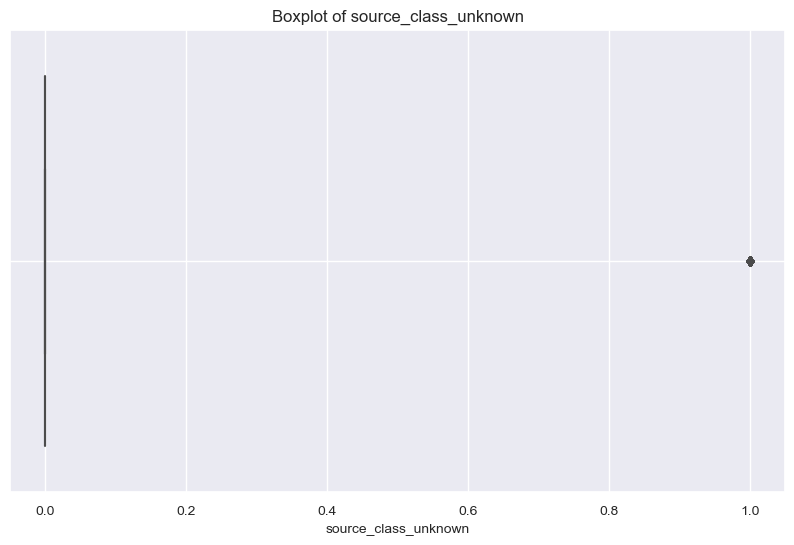

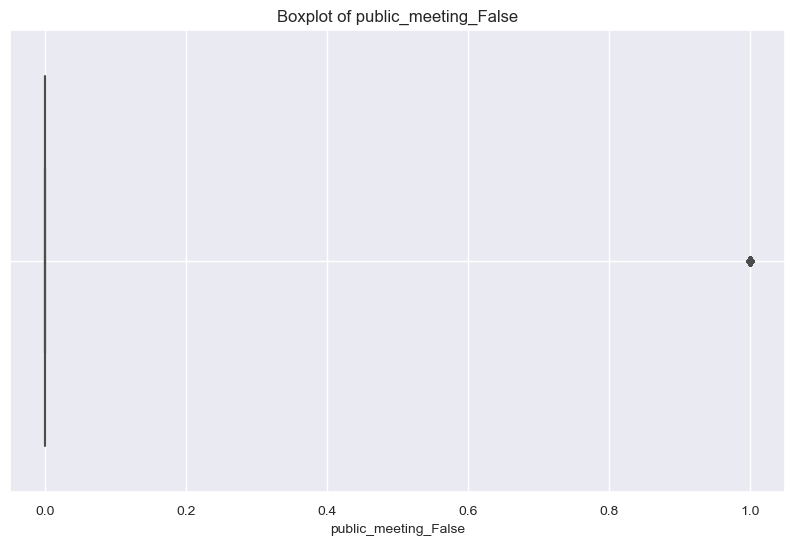

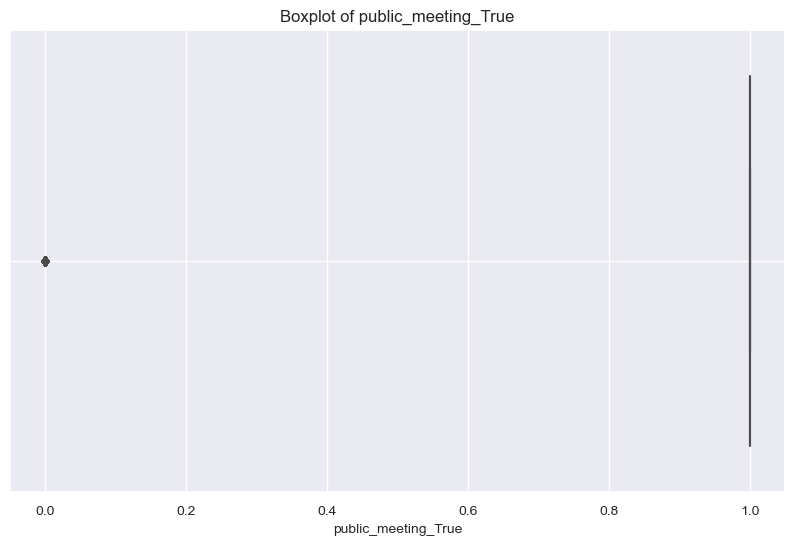

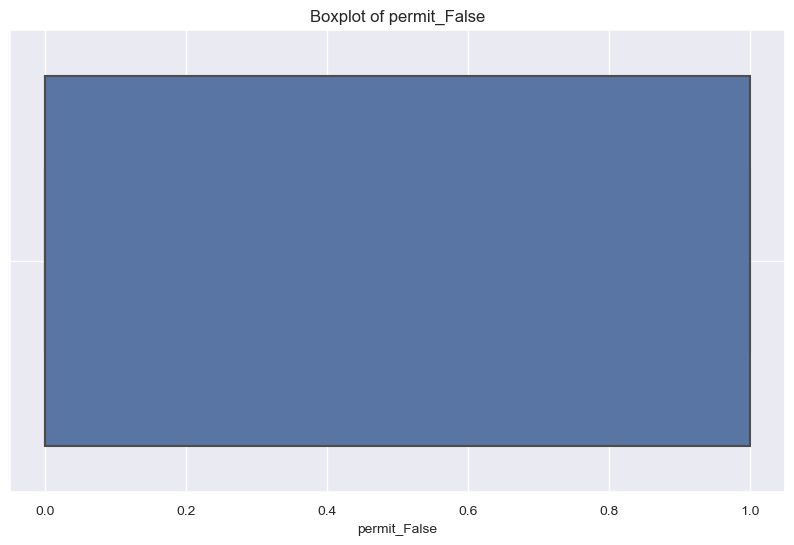

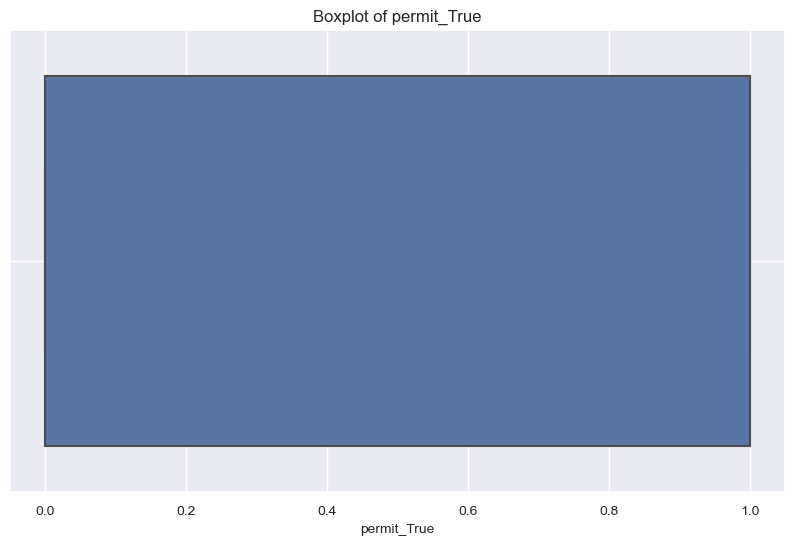

In [113]:
for column in full_df.columns:
    plt.figure(figsize=(10, 6))  
    sns.boxplot(x=full_df[column])  
    plt.title(f'Boxplot of {column}') 
    plt.grid(True)
    plt.show() 

In [114]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%fugas'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%fugas']>0) & (proporcion['Conteo']>10)]  
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%fugas'].values, linestyle='-', linewidth=2.0,color='g')
        plt.ylim(0, 100) # modificación.
        plt.tight_layout()   
        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%fugas', data=proporcion_filtered,fit_reg=True,ci=None)

C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leorq\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\l

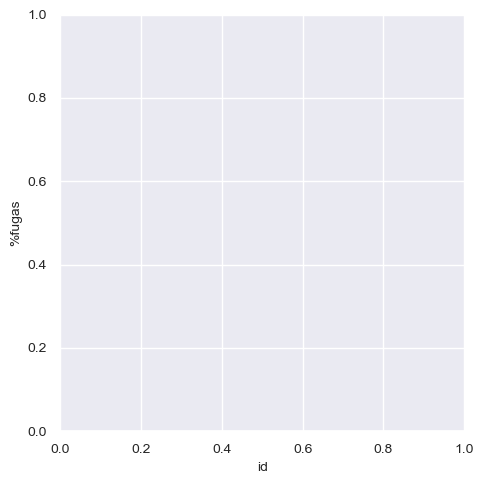

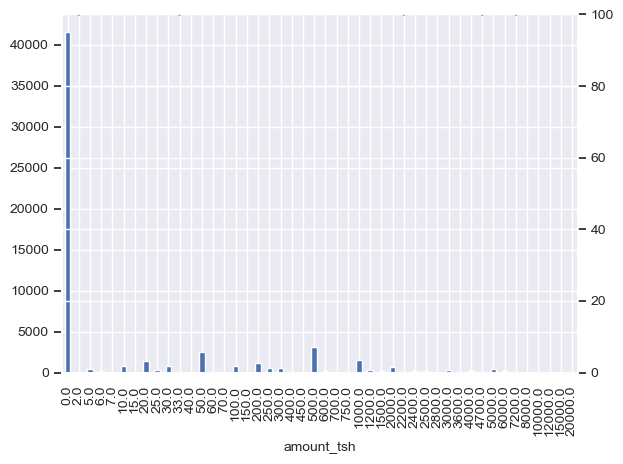

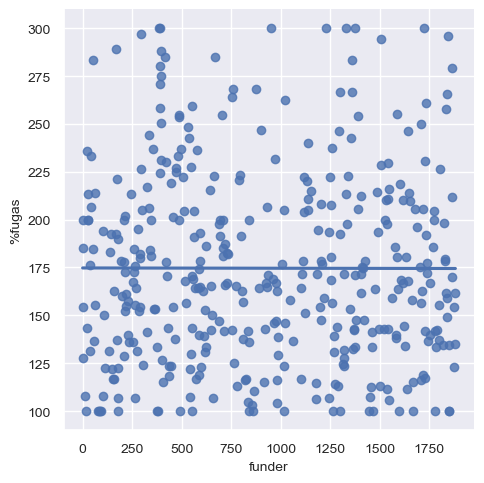

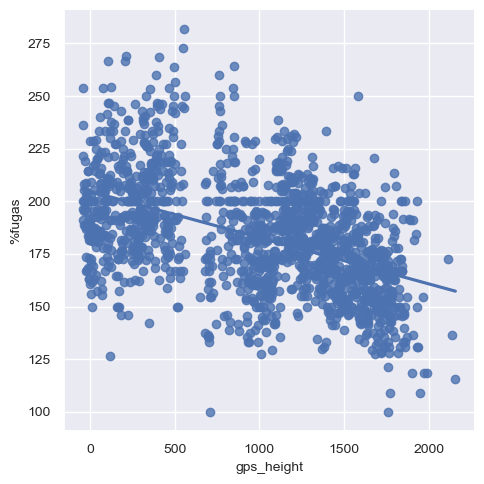

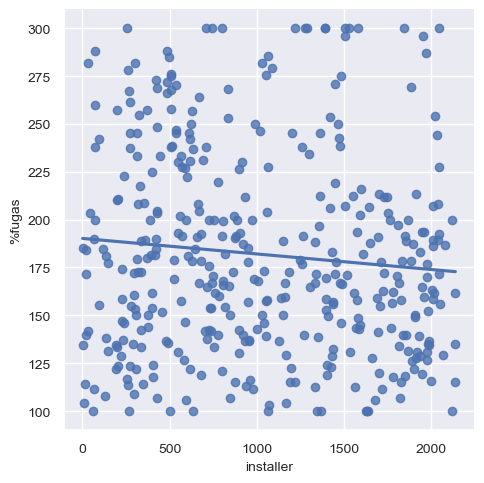

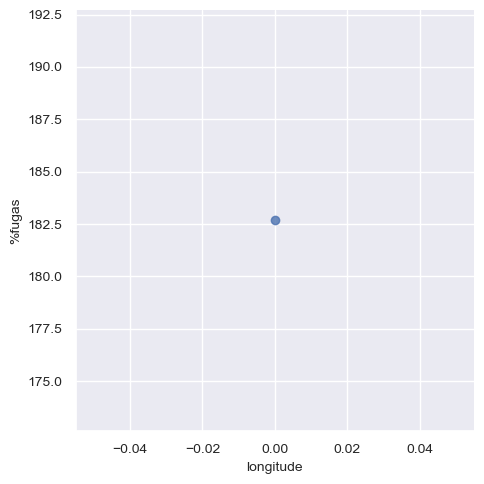

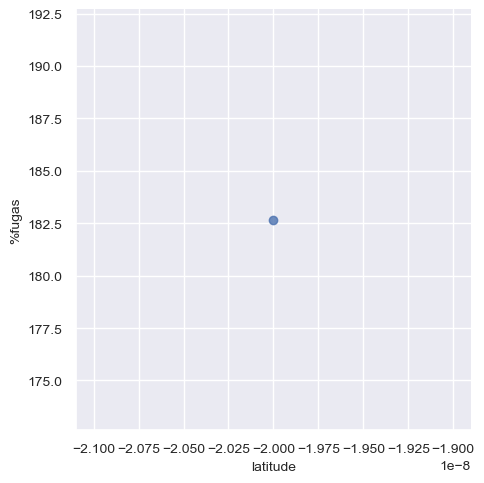

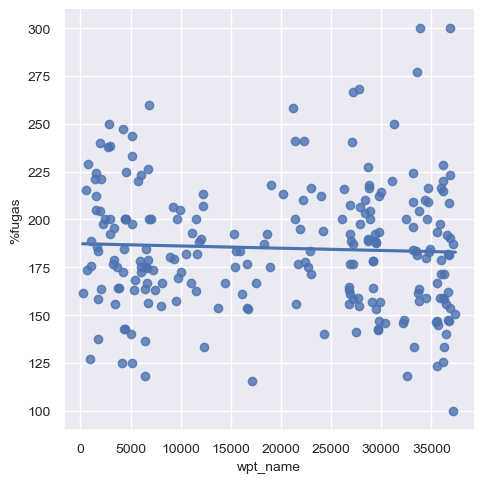

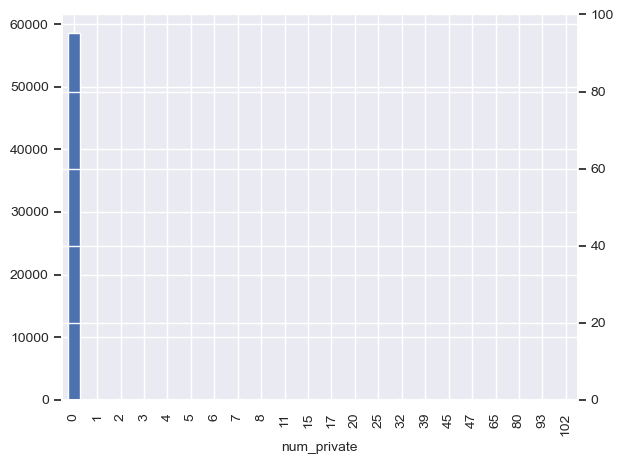

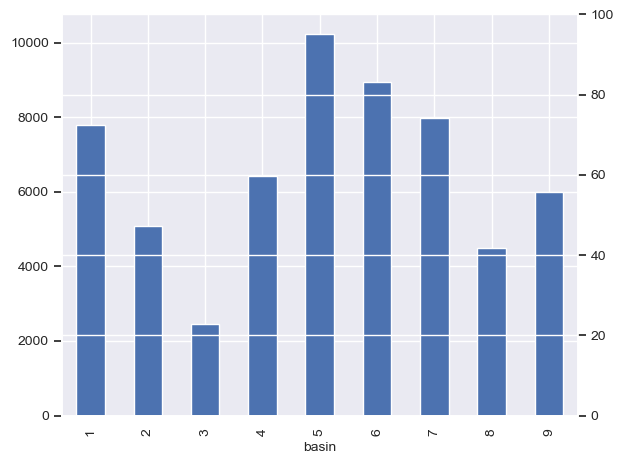

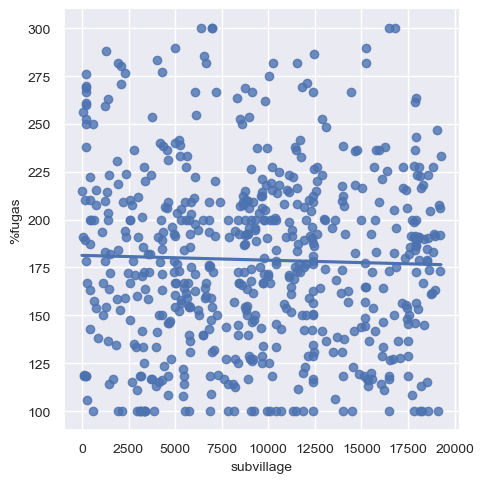

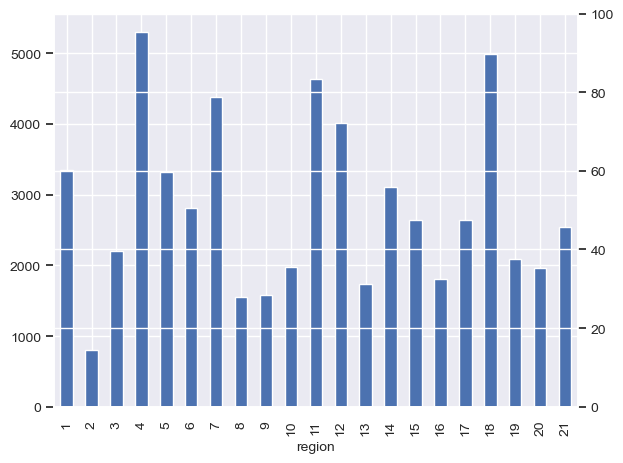

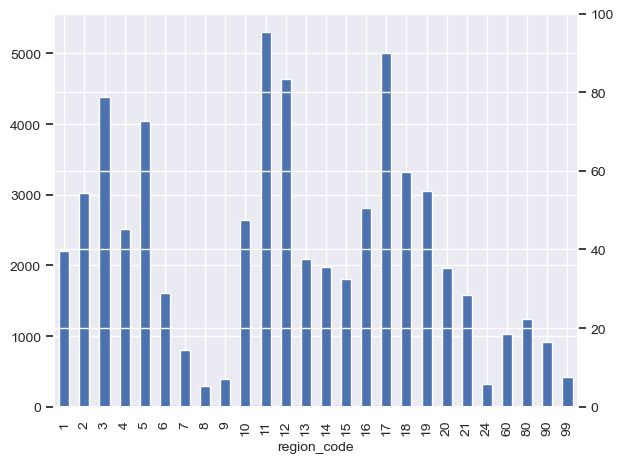

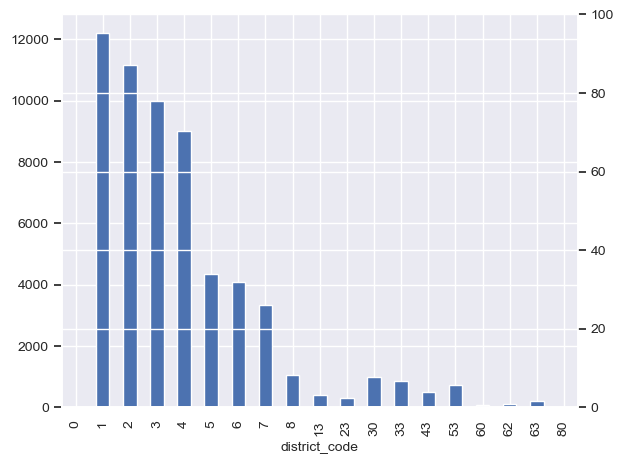

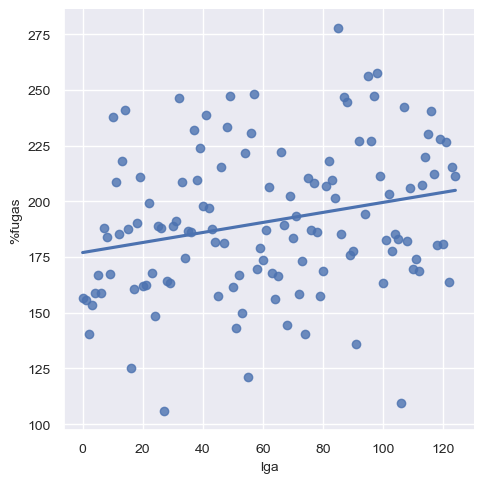

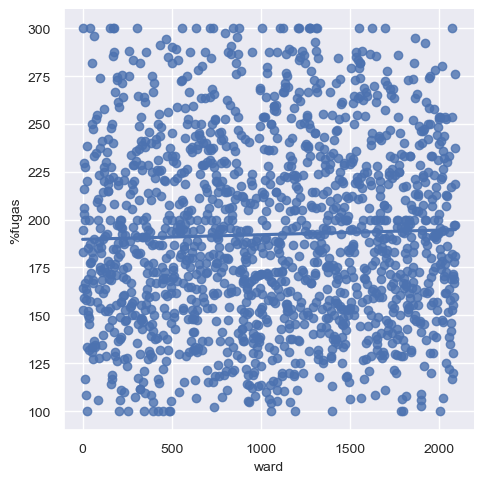

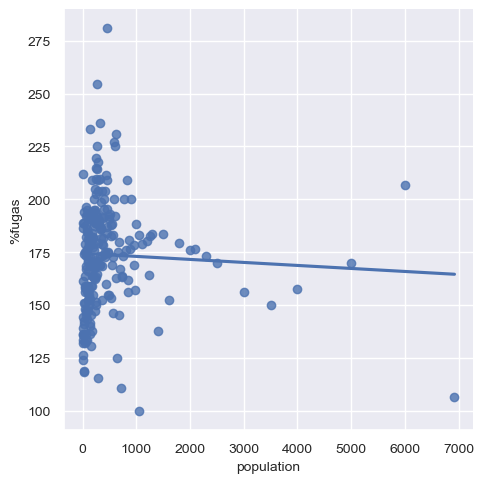

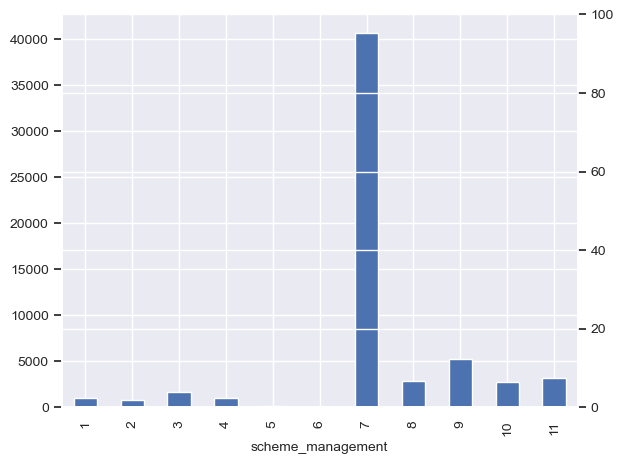

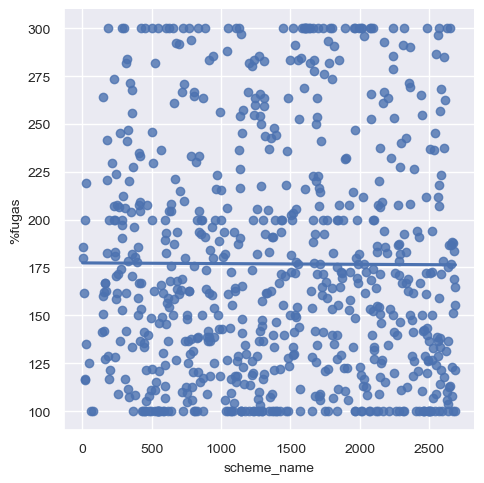

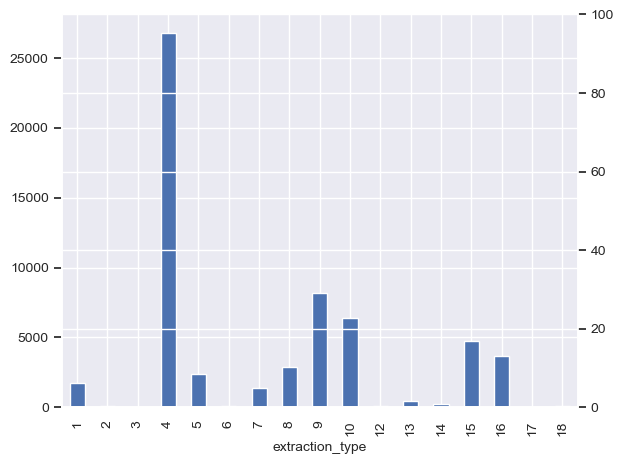

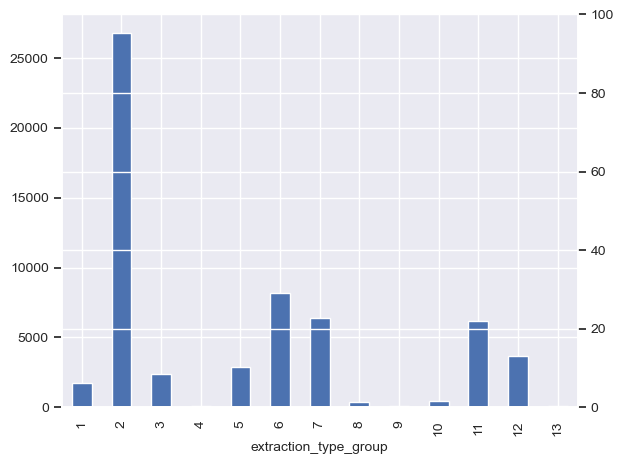

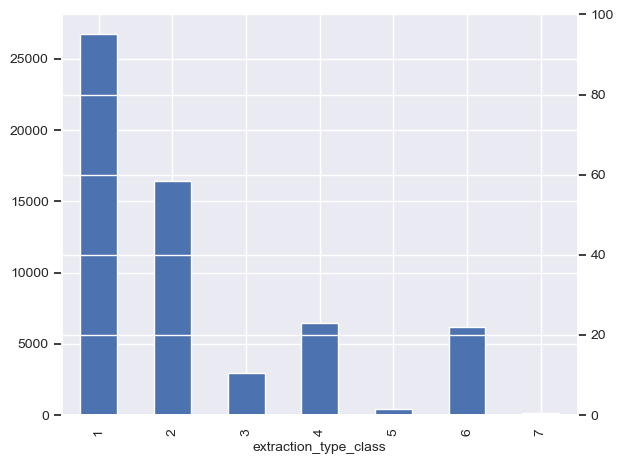

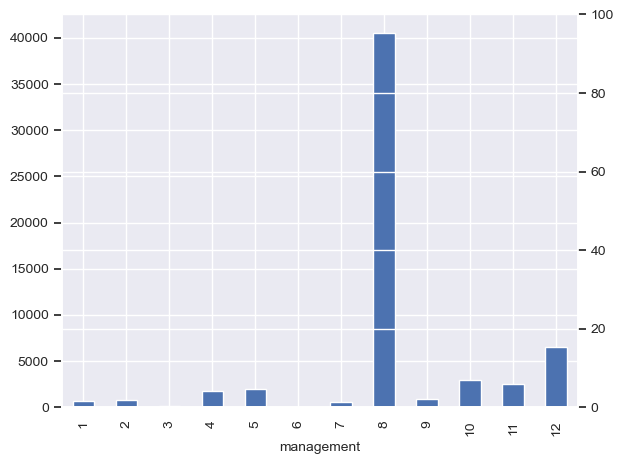

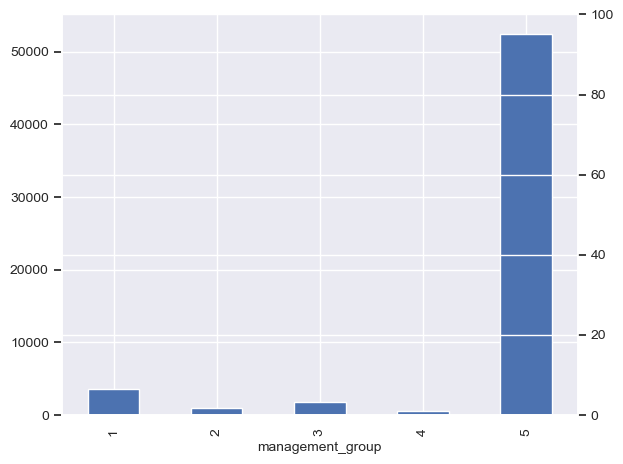

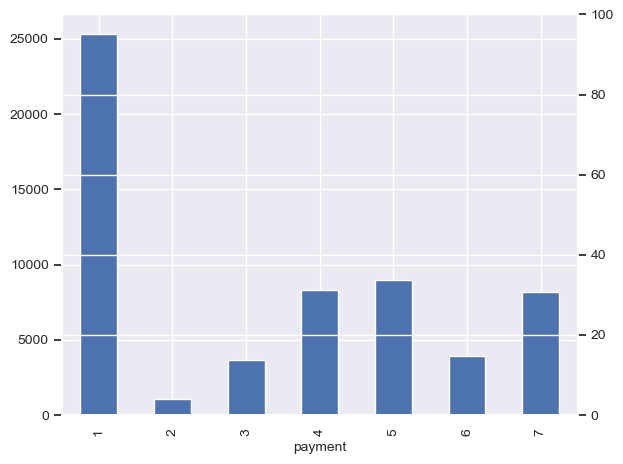

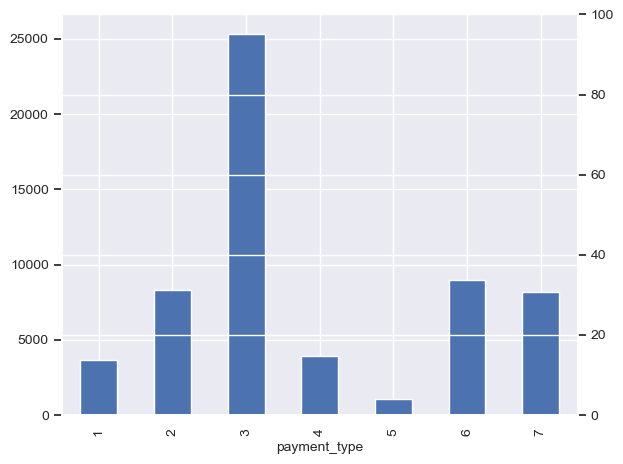

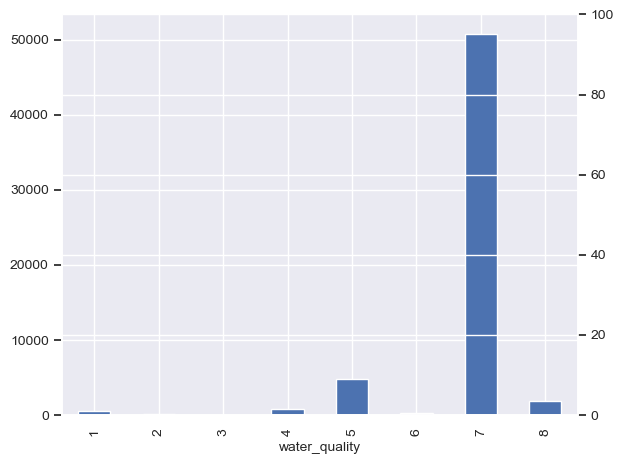

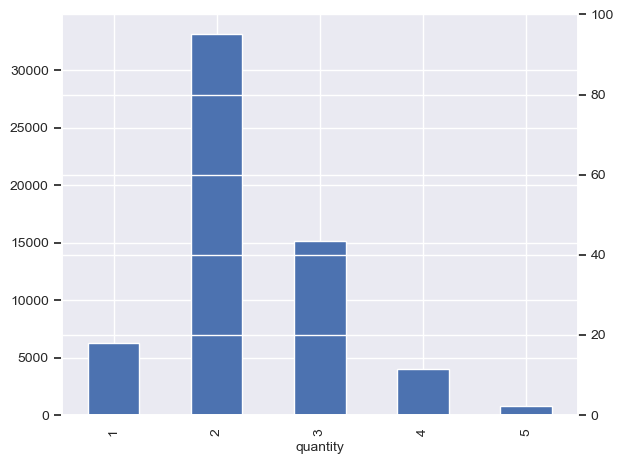

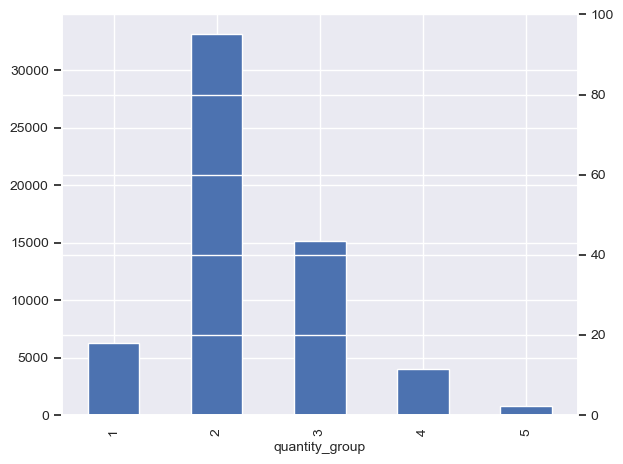

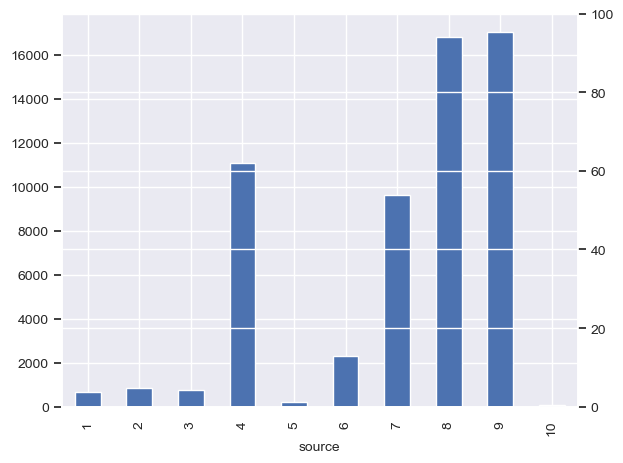

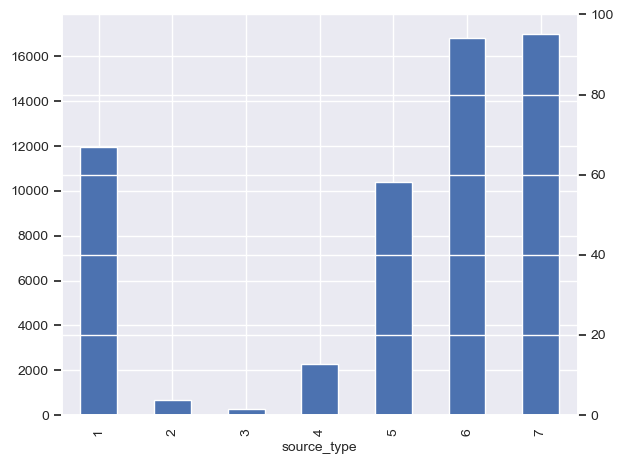

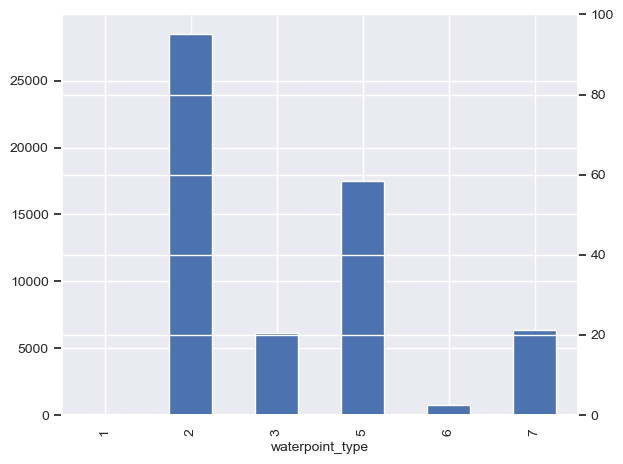

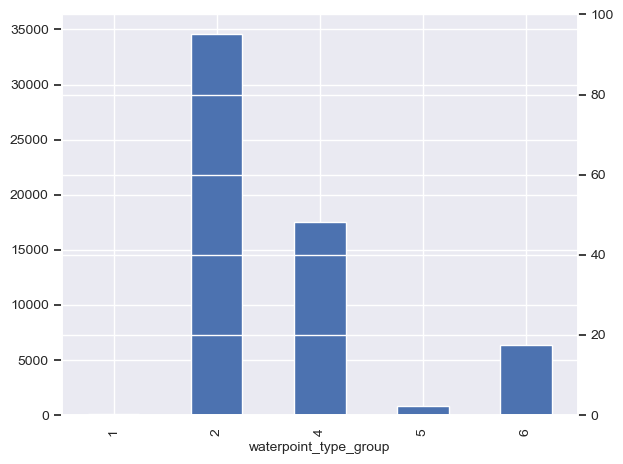

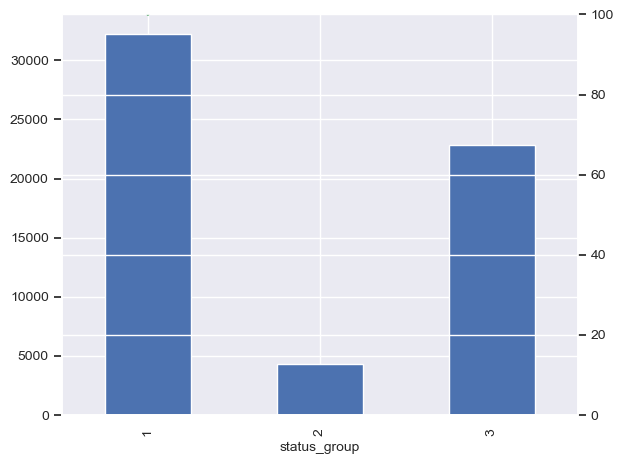

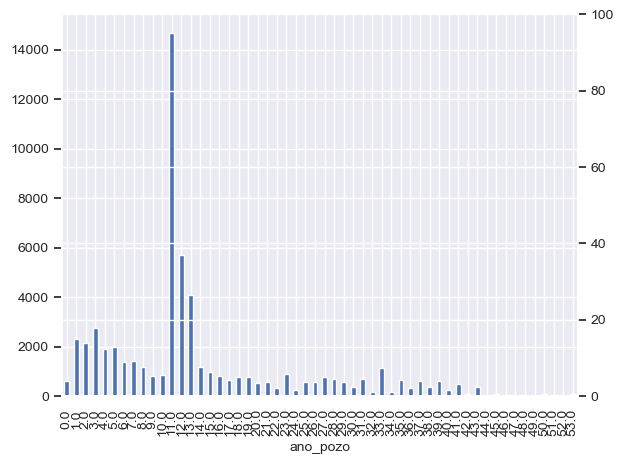

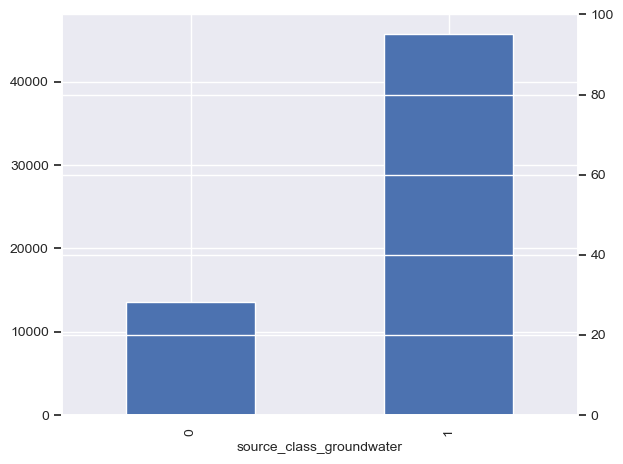

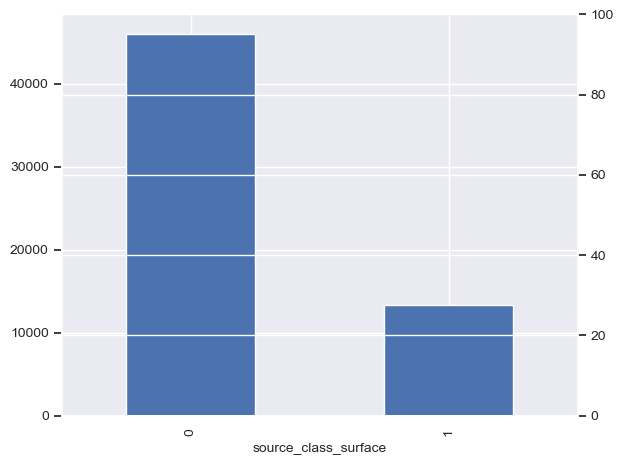

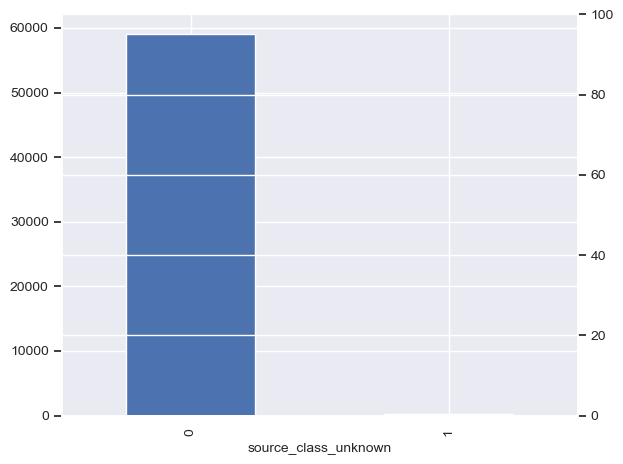

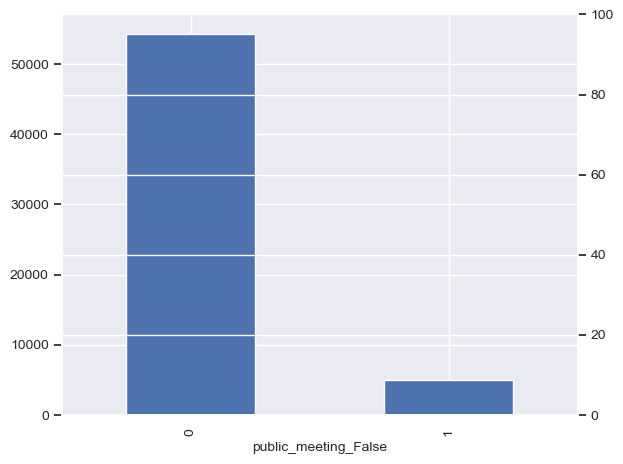

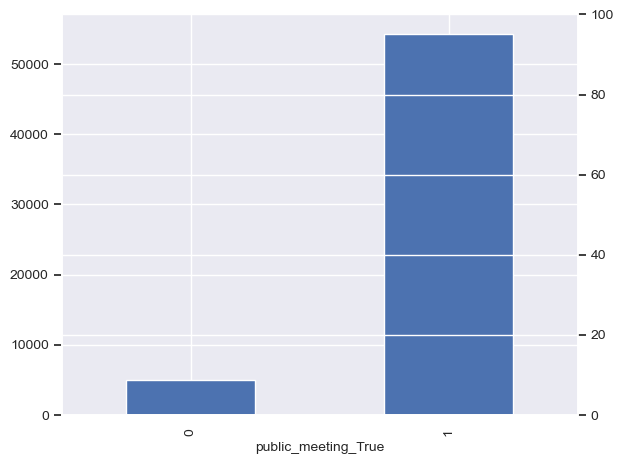

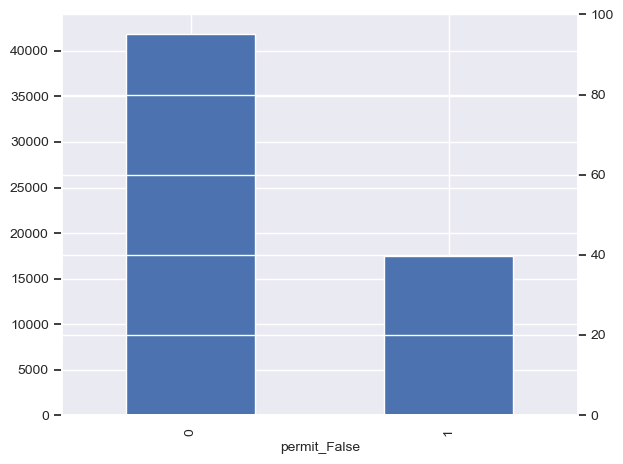

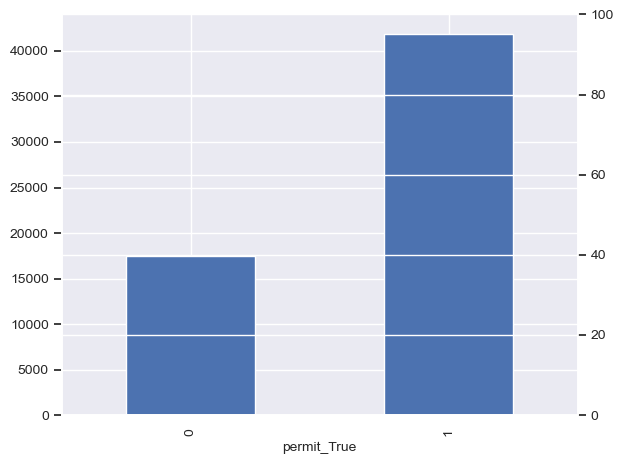

In [115]:
for i in full_df.columns:
    proporciones_final (i, 'status_group', full_df)

### Ahora voy a realizar el mismo preprocesado para mi csv de prueba (test_df)

In [116]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

Agrupo en dos variables, el grupo de variables de tipo object o categorica y en otro grupo las de tipo numerico para poder hacer un .describe() y evaluar las variables.

In [117]:
test_cat_cols = test_df.select_dtypes(include=['object']).columns
test_num_cols = test_df.select_dtypes(exclude=['object']).columns

In [118]:
test_df[test_cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14850,13980,13973,14850,14850,14751,14850,14850,14850,14029,14850,13881,7608,14113,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,331,979,1091,10840,9,8443,21,125,1959,2,1,11,1788,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2013-02-03,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,138,2215,4349,877,2623,140,1311,625,79,12738,14850,9124,176,9754,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


In [119]:
test_df[test_num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,21359.364833,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,10.000000,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18727.000000,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37361.500000,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [120]:
test_num_object_cols = len(test_cat_cols)
print(f"Número de columnas de tipo objeto: {test_num_object_cols}")

Número de columnas de tipo objeto: 30


In [121]:
test_num_int_float_cols = len(test_num_cols)
print(f"Número de columnas de tipo númerico: {test_num_int_float_cols}")

Número de columnas de tipo númerico: 10


Contamos con 30 variables tipo object/categórica y 10 variables de tipo numerica.

Creo la variable llamada ano pozo, anteriormente hecha en el full_df, eliminando luego date_recorded y construction_year.

In [123]:
test_df['date_recorded'] = pd.to_datetime(test_df['date_recorded'])
test_df['year_recorded'] = test_df['date_recorded'].dt.year

# Calcular la media de 'construction_year' excluyendo ceros
mean_year = test_df[test_df['construction_year'] > 0]['construction_year'].mean()

# Asegurarse de que 'construction_year' tiene sentido; reemplazar 0 con NaN y imputación por la media
test_df['construction_year'] = test_df['construction_year'].replace(0, np.nan)
test_df['construction_year'].fillna((test_df['construction_year'].median()), inplace=True)

# Calcular 'ano_pozo'
test_df['ano_pozo'] = test_df['year_recorded'] - test_df['construction_year']

# Reemplazar valores negativos en 'ano_pozo' con 0
test_df.loc[test_df['ano_pozo'] < 0, 'ano_pozo'] = 0

# Verificar los resultados
print("Valores únicos y sus frecuencias en 'ano_pozo' después de la limpieza:")
print(test_df['ano_pozo'].value_counts())
print("\nEstadísticas descriptivas de 'ano_pozo':")
print(test_df['ano_pozo'].describe())

Valores únicos y sus frecuencias en 'ano_pozo' después de la limpieza:
ano_pozo
11.0    3683
12.0    1495
13.0     985
3.0      650
1.0      600
2.0      594
5.0      510
4.0      438
7.0      405
6.0      351
14.0     293
8.0      280
33.0     255
15.0     249
16.0     237
19.0     203
23.0     203
9.0      192
10.0     192
27.0     187
31.0     186
18.0     184
28.0     182
17.0     164
25.0     161
21.0     149
29.0     147
0.0      144
35.0     140
26.0     133
41.0     133
37.0     131
20.0     130
39.0     127
38.0      90
36.0      86
30.0      78
22.0      77
43.0      70
40.0      62
24.0      61
34.0      49
32.0      42
42.0      23
50.0      21
53.0      20
45.0      14
44.0      11
51.0       7
48.0       7
46.0       7
52.0       5
47.0       4
49.0       3
Name: count, dtype: int64

Estadísticas descriptivas de 'ano_pozo':
count    14850.000000
mean        13.781145
std         10.075567
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000

In [124]:
test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,ano_pozo
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2013,1.0
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,13.0
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2013,3.0
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,2013,26.0
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,13.0


In [125]:
test_df.drop(['date_recorded', 'year_recorded', 'construction_year'], axis = 1, inplace = True)

Compruebo que la eliminacion fue correcta de las variables, mostrando de nuevo el dataframe test_df.

In [126]:
test_df

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.0
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,13.0
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,3.0
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,26.0
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,Yombo,Pwani,6,1,Bagamoyo,Yombo,20,True,GeoData Consultants Ltd,VWC,Bagamoyo wate,True,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,23.0
14846,18990,1000.0,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,Mkondoa,Tanga,4,7,Kilindi,Mvungwe,2960,True,GeoData Consultants Ltd,VWC,NaN,False,nira/tanira,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,17.0
14847,28749,0.0,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,Juhudi,Singida,13,2,Singida Rural,Ughandi,200,True,GeoData Consultants Ltd,VWC,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,3.0
14848,33492,0.0,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,Namakinga B,Ruvuma,10,2,Songea Rural,Maposeni,150,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa maposeni,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,4.0


In [127]:
new_test_cat_cols = test_df.select_dtypes(include=['object']).columns
new_test_num_cols = test_df.select_dtypes(exclude=['object']).columns

In [128]:
print(new_test_cat_cols)

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')


In [129]:
print(new_test_num_cols)

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'ano_pozo'],
      dtype='object')


Se han eliminado correctamente las columnas, que aportaban poco a nuestro modulo y si con una columna que nos generara un mejor enfoque.

#### Tratamiento de nulos

In [131]:
test_df.isnull().sum()

id                          0
amount_tsh                  0
funder                    870
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7242
permit                    737
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source    

In [132]:
test_df['wpt_name'].value_counts()

wpt_name
none                877
Shuleni             435
Zahanati            204
Msikitini           112
Sokoni               68
                   ... 
Kwa Gadau             1
Bubinza B             1
Nguvu Kazi A          1
Kwa Everigist         1
Kwa Mzee Chagala      1
Name: count, Length: 10840, dtype: int64

In [133]:
test_moda_wpt_name = test_df['wpt_name'].mode()[0]

test_df['wpt_name'].fillna(test_moda_wpt_name, inplace = True)

In [135]:
new_test_cat_cols = [col for col in new_test_cat_cols if col in test_df.columns]

test_df[new_test_cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,13980,13973,14850,14850,14751,14850,14850,14850,14029,14850,13881,7608,14113,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,979,1091,10840,9,8443,21,125,1959,2,1,11,1788,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,2215,4349,877,2623,140,1311,625,79,12738,14850,9124,176,9754,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


Vamos a proceder a imputar el resto de nulos.

In [136]:
for col in new_test_cat_cols:
    moda = test_df[col].mode()[0]
    test_df[col].fillna(moda, inplace=True)

In [137]:
test_df.isnull().sum()

id                       0
amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

#### Transformación variables a numéricas

In [138]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,K,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.0
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,13.0
2,17168,0.0,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,True,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,3.0
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,True,GeoData Consultants Ltd,VWC,K,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,26.0
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,True,GeoData Consultants Ltd,Water Board,BRUDER,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,13.0


In [139]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   funder                 14850 non-null  object 
 3   gps_height             14850 non-null  int64  
 4   installer              14850 non-null  object 
 5   longitude              14850 non-null  float64
 6   latitude               14850 non-null  float64
 7   wpt_name               14850 non-null  object 
 8   num_private            14850 non-null  int64  
 9   basin                  14850 non-null  object 
 10  subvillage             14850 non-null  object 
 11  region                 14850 non-null  object 
 12  region_code            14850 non-null  int64  
 13  district_code          14850 non-null  int64  
 14  lga                    14850 non-null  object 
 15  wa

In [141]:
test_df[new_test_cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,979,1091,10840,9,8443,21,125,1959,2,1,11,1788,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,3085,5226,877,2623,239,1311,625,79,13559,14850,10093,7418,10491,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


In [142]:
test_df['waterpoint_type_group'].sort_values().unique()

array(['cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [143]:
test_df.waterpoint_type_group.replace(('cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'), (1,2,3,4,5,6), inplace = True)

In [144]:
test_df['waterpoint_type'].sort_values().unique()

array(['cattle trough', 'communal standpipe',
       'communal standpipe multiple', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [145]:
test_df.waterpoint_type.replace(('cattle trough', 'communal standpipe', 'communal standpipe multiple', 'dam', 'hand pump',
       'improved spring', 'other'), (1,2,3,4,5,6,7), inplace = True)

Voy a proceder a pasar a dummies la variable source_class, ya que solo posee 3 valores diferentes.

In [146]:
test_df['source_class'].sort_values().unique()

array(['groundwater', 'surface', 'unknown'], dtype=object)

In [147]:
dummies3 = pd.get_dummies(test_df['source_class'], prefix='source_class')

In [148]:
test_df = pd.concat([test_df, dummies3], axis=1)

In [149]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,K,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,7,6,1.0,False,True,False
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,2,2,13.0,True,False,False
2,17168,0.0,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,True,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,7,6,3.0,False,True,False
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,True,GeoData Consultants Ltd,VWC,K,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,7,6,26.0,True,False,False
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,True,GeoData Consultants Ltd,Water Board,BRUDER,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,2,2,13.0,True,False,False


In [150]:
test_df['source_class_groundwater'] = test_df['source_class_groundwater'].astype(int)

In [153]:
test_df['source_class_surface'] = test_df['source_class_surface'].astype(int)

In [154]:
test_df['source_class_unknown'] = test_df['source_class_unknown'].astype(int)

In [155]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,K,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,7,6,1.0,0,1,0
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,2,2,13.0,1,0,0
2,17168,0.0,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,True,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,7,6,3.0,0,1,0
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,True,GeoData Consultants Ltd,VWC,K,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,7,6,26.0,1,0,0
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,True,GeoData Consultants Ltd,Water Board,BRUDER,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,2,2,13.0,1,0,0


Pase las variables dummies que se habian pasado en true y false, las pase a numericas.

In [156]:
test_df['source_type'].sort_values().unique()

array(['borehole', 'dam', 'other', 'rainwater harvesting', 'river/lake',
       'shallow well', 'spring'], dtype=object)

In [157]:
test_df.source_type.replace(('borehole', 'dam', 'other', 'rainwater harvesting', 'river/lake',
       'shallow well', 'spring'), (1,2,3,4,5,6,7), inplace = True)

In [158]:
test_df['source'].sort_values().unique()

array(['dam', 'hand dtw', 'lake', 'machine dbh', 'other',
       'rainwater harvesting', 'river', 'shallow well', 'spring',
       'unknown'], dtype=object)

In [159]:
test_df.source.replace(('dam', 'hand dtw', 'lake', 'machine dbh', 'other',
       'rainwater harvesting', 'river', 'shallow well', 'spring',
       'unknown'), (1,2,3,4,5,6,7,8,9,10), inplace = True)

In [160]:
test_df['quantity_group'].sort_values().unique()

array(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'],
      dtype=object)

In [161]:
test_df.quantity_group.replace(('dry', 'enough', 'insufficient', 'seasonal', 'unknown'), (1,2,3,4,5), inplace = True)

In [162]:
test_df['quantity'].sort_values().unique()

array(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'],
      dtype=object)

In [163]:
test_df.quantity.replace(('dry', 'enough', 'insufficient', 'seasonal', 'unknown'), (1,2,3,4,5), inplace = True)

In [164]:
test_df['quality_group'].sort_values().unique()

array(['colored', 'fluoride', 'good', 'milky', 'salty', 'unknown'],
      dtype=object)

In [165]:
test_df.quality_group.replace(('colored', 'fluoride', 'good', 'milky', 'salty', 'unknown'), (1,2,3,4,5,6), inplace = True)

In [166]:
test_df['water_quality'].sort_values().unique()

array(['coloured', 'fluoride', 'fluoride abandoned', 'milky', 'salty',
       'salty abandoned', 'soft', 'unknown'], dtype=object)

In [167]:
test_df.water_quality.replace(('coloured', 'fluoride', 'fluoride abandoned', 'milky', 'salty',
       'salty abandoned', 'soft', 'unknown'), (1,2,3,4,5,6,7,8), inplace = True)

In [168]:
test_df['payment_type'].sort_values().unique()

array(['annually', 'monthly', 'never pay', 'on failure', 'other',
       'per bucket', 'unknown'], dtype=object)

In [169]:
test_df.payment_type.replace(('annually', 'monthly', 'never pay', 'on failure', 'other',
       'per bucket', 'unknown'), (1,2,3,4,5,6,7), inplace = True)

In [170]:
test_df['payment'].sort_values().unique()

array(['never pay', 'other', 'pay annually', 'pay monthly',
       'pay per bucket', 'pay when scheme fails', 'unknown'], dtype=object)

In [171]:
test_df.payment.replace(('never pay', 'other', 'pay annually', 'pay monthly',
       'pay per bucket', 'pay when scheme fails', 'unknown'), (1,2,3,4,5,6,7), inplace = True)

In [172]:
test_df['management_group'].sort_values().unique()

array(['commercial', 'other', 'parastatal', 'unknown', 'user-group'],
      dtype=object)

In [173]:
test_df.management_group.replace(('commercial', 'other', 'parastatal', 'unknown', 'user-group'), (1,2,3,4,5), inplace = True)

In [174]:
test_df['management'].sort_values().unique()

array(['company', 'other', 'other - school', 'parastatal',
       'private operator', 'trust', 'unknown', 'vwc', 'water authority',
       'water board', 'wua', 'wug'], dtype=object)

In [175]:
test_df.management.replace(('company', 'other', 'other - school', 'parastatal',
       'private operator', 'trust', 'unknown', 'vwc', 'water authority',
       'water board', 'wua', 'wug'), (1,2,3,4,5,6,7,8,9,10,11,12), inplace = True)

In [176]:
test_df['extraction_type_class'].sort_values().unique()

array(['gravity', 'handpump', 'motorpump', 'other', 'rope pump',
       'submersible', 'wind-powered'], dtype=object)

In [177]:
test_df.extraction_type_class.replace(('gravity', 'handpump', 'motorpump', 'other', 'rope pump',
       'submersible', 'wind-powered'), (1,2,3,4,5,6,7), inplace = True)

In [178]:
test_df['extraction_type_group'].sort_values().unique()

array(['afridev', 'gravity', 'india mark ii', 'india mark iii', 'mono',
       'nira/tanira', 'other', 'other handpump', 'other motorpump',
       'rope pump', 'submersible', 'swn 80', 'wind-powered'], dtype=object)

In [179]:
test_df.extraction_type_group.replace(('afridev', 'gravity', 'india mark ii', 'india mark iii', 'mono',
       'nira/tanira', 'other', 'other handpump', 'other motorpump',
       'rope pump', 'submersible', 'swn 80', 'wind-powered'), (1,2,3,4,5,6,7,8,9,10,11,12,13), inplace = True)

In [180]:
test_df['extraction_type'].sort_values().unique()

array(['afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other',
       'other - play pump', 'other - rope pump', 'other - swn 81',
       'submersible', 'swn 80', 'walimi', 'windmill'], dtype=object)

In [181]:
test_df.extraction_type.replace(('afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other',
       'other - mkulima/shinyanga', 'other - play pump',
       'other - rope pump', 'other - swn 81', 'submersible', 'swn 80',
       'walimi', 'windmill'), (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18), inplace = True)

In [182]:
test_df['scheme_management'].sort_values().unique()

array(['Company', 'Other', 'Parastatal', 'Private operator', 'SWC',
       'Trust', 'VWC', 'WUA', 'WUG', 'Water Board', 'Water authority'],
      dtype=object)

In [183]:
test_df.scheme_management.replace(('Company', 'Other', 'Parastatal', 'Private operator', 'SWC',
       'Trust', 'VWC', 'WUA', 'WUG', 'Water Board', 'Water authority'), (1,2,3,4,5,6,7,8,9,10,11), inplace = True)

In [184]:
test_df['region'].sort_values().unique()

array(['Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kagera', 'Kigoma',
       'Kilimanjaro', 'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro',
       'Mtwara', 'Mwanza', 'Pwani', 'Rukwa', 'Ruvuma', 'Shinyanga',
       'Singida', 'Tabora', 'Tanga'], dtype=object)

In [185]:
test_df.region.replace(('Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kagera', 'Kigoma',
       'Kilimanjaro', 'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro',
       'Mtwara', 'Mwanza', 'Pwani', 'Rukwa', 'Ruvuma', 'Shinyanga',
       'Singida', 'Tabora', 'Tanga'), (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21), inplace = True)

In [186]:
test_df['basin'].sort_values().unique()

array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu'], dtype=object)

In [187]:
test_df.basin.replace(('Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
       'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
       'Wami / Ruvu'), (1,2,3,4,5,6,7,8,9), inplace = True)

He terminado la transformacion de variables manual, ahora voy a proceder a los que tienen muchos valores unicos y las transformare a traves del LabelEncoder() anteriormente dicho.

In [188]:
test_df['scheme_name'] = le.fit_transform(test_df['scheme_name'])

In [189]:
test_df['ward'] = le.fit_transform(test_df['ward'])

In [190]:
test_df['lga'] = le.fit_transform(test_df['lga'])

In [191]:
test_df['subvillage'] = le.fit_transform(test_df['subvillage'])

In [192]:
test_df['wpt_name'] = le.fit_transform(test_df['wpt_name'])

In [193]:
test_df['installer'] = le.fit_transform(test_df['installer'])

In [194]:
test_df['funder'] = le.fit_transform(test_df['funder'])

Mostrar como esta el dataframe para ver que tal va la transformacion a númericas.

In [195]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown
0,50785,0.0,175,1996,214,35.290799,-4.059696,656,0,1,3916,9,21,3,63,17,321,True,GeoData Consultants Ltd,3,395,True,10,7,4,4,3,1,3,7,3,4,4,6,4,surface,7,6,1.0,0,1,0
1,51630,0.0,250,1569,221,36.656709,-3.309214,1780,0,6,2717,1,2,2,0,650,300,True,GeoData Consultants Ltd,7,1609,True,4,2,1,8,5,1,3,7,3,3,3,9,7,groundwater,2,2,13.0,1,0,0
2,17168,0.0,250,1567,221,34.767863,-5.004344,9673,0,1,5398,19,13,2,109,1677,500,True,GeoData Consultants Ltd,7,1452,True,10,7,4,8,5,1,3,7,3,3,3,6,4,surface,7,6,3.0,0,1,0
3,45559,0.0,222,267,262,38.058046,-9.418672,5595,0,8,2795,8,80,43,49,1192,250,True,GeoData Consultants Ltd,7,395,True,10,7,4,8,5,7,7,7,3,1,1,8,6,groundwater,7,6,26.0,1,0,0
4,49871,500.0,73,1260,75,35.006123,-10.950412,5706,0,8,3544,17,10,3,61,1075,60,True,GeoData Consultants Ltd,10,76,True,4,2,1,10,5,4,2,7,3,2,2,9,7,groundwater,2,2,13.0,1,0,0


Me falta hacerle .drop() a las variables recorded_by y a source_class que ya la habia convertido a dummies, pero primero pasare a dummies public_permit y permit.

In [196]:
dummies4 = pd.get_dummies(test_df['public_meeting'], prefix='public_meeting', drop_first=False)

In [197]:
test_df = pd.concat([test_df, dummies4], axis=1)

In [198]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True
0,50785,0.0,175,1996,214,35.290799,-4.059696,656,0,1,3916,9,21,3,63,17,321,True,GeoData Consultants Ltd,3,395,True,10,7,4,4,3,1,3,7,3,4,4,6,4,surface,7,6,1.0,0,1,0,False,True
1,51630,0.0,250,1569,221,36.656709,-3.309214,1780,0,6,2717,1,2,2,0,650,300,True,GeoData Consultants Ltd,7,1609,True,4,2,1,8,5,1,3,7,3,3,3,9,7,groundwater,2,2,13.0,1,0,0,False,True
2,17168,0.0,250,1567,221,34.767863,-5.004344,9673,0,1,5398,19,13,2,109,1677,500,True,GeoData Consultants Ltd,7,1452,True,10,7,4,8,5,1,3,7,3,3,3,6,4,surface,7,6,3.0,0,1,0,False,True
3,45559,0.0,222,267,262,38.058046,-9.418672,5595,0,8,2795,8,80,43,49,1192,250,True,GeoData Consultants Ltd,7,395,True,10,7,4,8,5,7,7,7,3,1,1,8,6,groundwater,7,6,26.0,1,0,0,False,True
4,49871,500.0,73,1260,75,35.006123,-10.950412,5706,0,8,3544,17,10,3,61,1075,60,True,GeoData Consultants Ltd,10,76,True,4,2,1,10,5,4,2,7,3,2,2,9,7,groundwater,2,2,13.0,1,0,0,False,True


In [199]:
test_df['public_meeting_False'] = test_df['public_meeting_False'].astype(int)

In [200]:
test_df['public_meeting_True'] = test_df['public_meeting_True'].astype(int)

In [201]:
dummies5 = pd.get_dummies(test_df['permit'], prefix='permit', drop_first=False)

In [202]:
test_df = pd.concat([test_df, dummies5], axis=1)

In [203]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,50785,0.0,175,1996,214,35.290799,-4.059696,656,0,1,3916,9,21,3,63,17,321,True,GeoData Consultants Ltd,3,395,True,10,7,4,4,3,1,3,7,3,4,4,6,4,surface,7,6,1.0,0,1,0,0,1,False,True
1,51630,0.0,250,1569,221,36.656709,-3.309214,1780,0,6,2717,1,2,2,0,650,300,True,GeoData Consultants Ltd,7,1609,True,4,2,1,8,5,1,3,7,3,3,3,9,7,groundwater,2,2,13.0,1,0,0,0,1,False,True
2,17168,0.0,250,1567,221,34.767863,-5.004344,9673,0,1,5398,19,13,2,109,1677,500,True,GeoData Consultants Ltd,7,1452,True,10,7,4,8,5,1,3,7,3,3,3,6,4,surface,7,6,3.0,0,1,0,0,1,False,True
3,45559,0.0,222,267,262,38.058046,-9.418672,5595,0,8,2795,8,80,43,49,1192,250,True,GeoData Consultants Ltd,7,395,True,10,7,4,8,5,7,7,7,3,1,1,8,6,groundwater,7,6,26.0,1,0,0,0,1,False,True
4,49871,500.0,73,1260,75,35.006123,-10.950412,5706,0,8,3544,17,10,3,61,1075,60,True,GeoData Consultants Ltd,10,76,True,4,2,1,10,5,4,2,7,3,2,2,9,7,groundwater,2,2,13.0,1,0,0,0,1,False,True


In [204]:
test_df['permit_False'] = test_df['permit_False'].astype(int)

In [205]:
test_df['permit_True'] = test_df['permit_True'].astype(int)

In [206]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,50785,0.0,175,1996,214,35.290799,-4.059696,656,0,1,3916,9,21,3,63,17,321,True,GeoData Consultants Ltd,3,395,True,10,7,4,4,3,1,3,7,3,4,4,6,4,surface,7,6,1.0,0,1,0,0,1,0,1
1,51630,0.0,250,1569,221,36.656709,-3.309214,1780,0,6,2717,1,2,2,0,650,300,True,GeoData Consultants Ltd,7,1609,True,4,2,1,8,5,1,3,7,3,3,3,9,7,groundwater,2,2,13.0,1,0,0,0,1,0,1
2,17168,0.0,250,1567,221,34.767863,-5.004344,9673,0,1,5398,19,13,2,109,1677,500,True,GeoData Consultants Ltd,7,1452,True,10,7,4,8,5,1,3,7,3,3,3,6,4,surface,7,6,3.0,0,1,0,0,1,0,1
3,45559,0.0,222,267,262,38.058046,-9.418672,5595,0,8,2795,8,80,43,49,1192,250,True,GeoData Consultants Ltd,7,395,True,10,7,4,8,5,7,7,7,3,1,1,8,6,groundwater,7,6,26.0,1,0,0,0,1,0,1
4,49871,500.0,73,1260,75,35.006123,-10.950412,5706,0,8,3544,17,10,3,61,1075,60,True,GeoData Consultants Ltd,10,76,True,4,2,1,10,5,4,2,7,3,2,2,9,7,groundwater,2,2,13.0,1,0,0,0,1,0,1


Elimino todas las variables que ya no son necesarias en mi dataframe test.df

In [207]:
test_df.drop(['source_class', 'recorded_by', 'quality_group', 'public_meeting', 'permit'], axis = 1, inplace = True)

In [208]:
test_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,scheme_name,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,ano_pozo,source_class_groundwater,source_class_surface,source_class_unknown,public_meeting_False,public_meeting_True,permit_False,permit_True
0,50785,0.0,175,1996,214,35.290799,-4.059696,656,0,1,3916,9,21,3,63,17,321,3,395,10,7,4,4,3,1,3,7,4,4,6,4,7,6,1.0,0,1,0,0,1,0,1
1,51630,0.0,250,1569,221,36.656709,-3.309214,1780,0,6,2717,1,2,2,0,650,300,7,1609,4,2,1,8,5,1,3,7,3,3,9,7,2,2,13.0,1,0,0,0,1,0,1
2,17168,0.0,250,1567,221,34.767863,-5.004344,9673,0,1,5398,19,13,2,109,1677,500,7,1452,10,7,4,8,5,1,3,7,3,3,6,4,7,6,3.0,0,1,0,0,1,0,1
3,45559,0.0,222,267,262,38.058046,-9.418672,5595,0,8,2795,8,80,43,49,1192,250,7,395,10,7,4,8,5,7,7,7,1,1,8,6,7,6,26.0,1,0,0,0,1,0,1
4,49871,500.0,73,1260,75,35.006123,-10.950412,5706,0,8,3544,17,10,3,61,1075,60,10,76,4,2,1,10,5,4,2,7,2,2,9,7,2,2,13.0,1,0,0,0,1,0,1


Ahora mi dataframe parece estar todo con valores numericos

In [209]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        14850 non-null  int64  
 1   amount_tsh                14850 non-null  float64
 2   funder                    14850 non-null  int32  
 3   gps_height                14850 non-null  int64  
 4   installer                 14850 non-null  int32  
 5   longitude                 14850 non-null  float64
 6   latitude                  14850 non-null  float64
 7   wpt_name                  14850 non-null  int32  
 8   num_private               14850 non-null  int64  
 9   basin                     14850 non-null  int64  
 10  subvillage                14850 non-null  int32  
 11  region                    14850 non-null  int64  
 12  region_code               14850 non-null  int64  
 13  district_code             14850 non-null  int64  
 14  lga   

### Muestrear los datos, construyendo un dataset de train y test

Creo el muestreo, coloco primero el dataframe con las variables independientes y luego coloco la variable objectivo individual.

In [211]:
X_train, X_val, y_train, y_val = train_test_split(full_df.drop('status_group', axis = 1),
                                                  full_df['status_group'],
                                                  test_size = 0.2,
                                                  random_state = 42,
                                                  stratify = full_df['status_group']
                                                 )

### Construir un modelo analítico de clasificación

Entrenar y predecir el modelo.

In [212]:
model = RandomForestClassifier(random_state = 42).fit(X_train, y_train)
y_val_pred = model.predict(X_val)

In [213]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           1       0.80      0.90      0.85      6452
           2       0.57      0.30      0.40       863
           3       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.74      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



Hacer una matriz de confusion para evaluar el modelo obtenido.

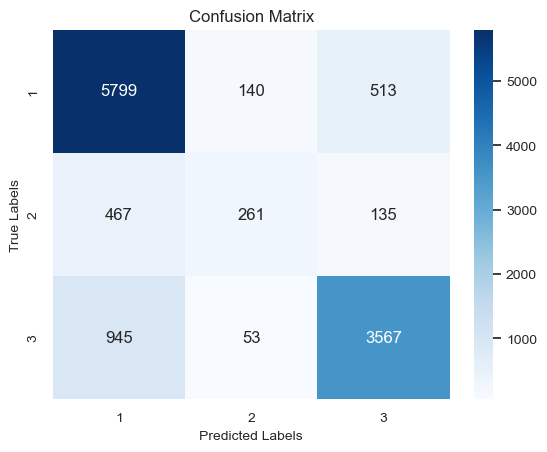

In [214]:
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Realizo este procedimiento para obtener el AUC para cada una de las clases y saber como se comporta su curva ROC a tráves de un gráfico.

AUC Micro-average: 0.9380917090376265
AUC Macro-average: 0.9013064603912282


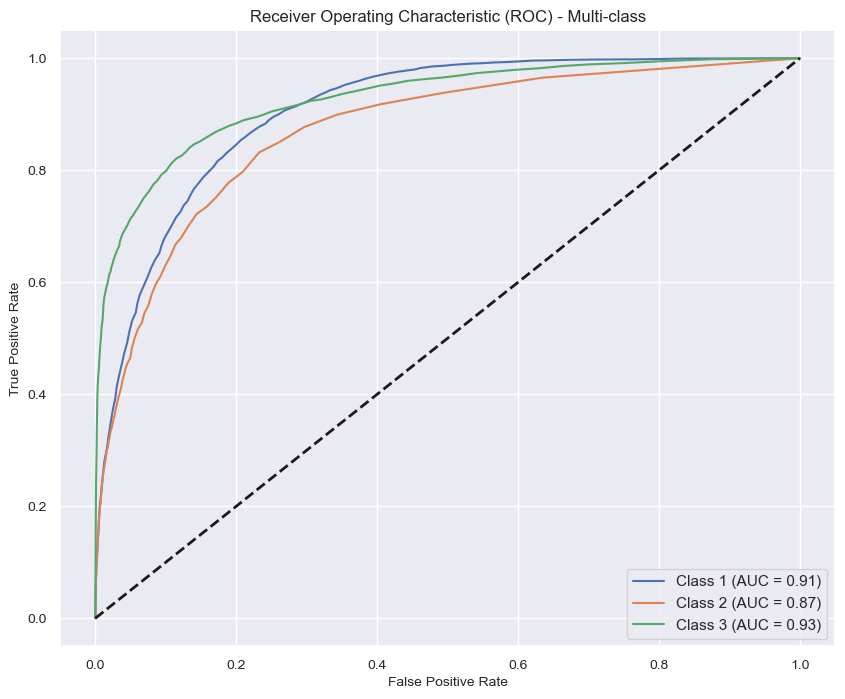

In [218]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_prob = model.predict_proba(X_val)  # Probabilidades para ROC

# Binarizar las etiquetas verdaderas para multiclase ROC
y_val_binarized = label_binarize(y_val, classes=model.classes_)

# Calcular AUC utilizando enfoques micro y macro
roc_auc_micro = roc_auc_score(y_val_binarized, y_prob, average='micro')
roc_auc_macro = roc_auc_score(y_val_binarized, y_prob, average='macro')

print(f'AUC Micro-average: {roc_auc_micro}')
print(f'AUC Macro-average: {roc_auc_macro}')

# Calcular ROC y AUC para cada clase
n_classes = y_val_binarized.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(model.classes_):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_label} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-class')
plt.legend(loc="lower right")
plt.show()

Realizar predicciones sobre el conjunto de test

In [220]:
y_test_pred = model.predict(test_df)

Crear el archivo de envío y nombre del csv de exportación

In [221]:
submission_format_df['status_group'] = y_test_pred
submission_format_df.to_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\my_submission.csv", index=False)

Hago la lectura del CSV que cree y exporté con las predicciones llamado "my_submission_df".

In [222]:
my_submission_df = pd.read_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\my_submission.csv")

Lo muestro para ver el formato y si se realizo correctamente.

In [223]:
my_submission_df.head()

,id,status_group
0,50785,3
1,51630,1
2,17168,1
3,45559,3
4,49871,1


Convierto nuevamente las variables numericas 1,2,3 a variables de tipo string con su debido nombre para una mejor interpretacion de cada categoria.

In [224]:
my_submission_df['status_group'].sort_values().unique()

array([1, 2, 3], dtype=int64)

In [225]:
my_submission_df.status_group.replace((1,2,3), ('functional', 'functional needs repair', 'non functional'), inplace = True)

Vuelvo a guardarlo para submeterlo en el concurso.

In [226]:
my_submission_df.to_csv("C:\\Users\\leorq\\Documents\\LEO\\MASTER UCM DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS\\MODULO 8 - Machine Learning (3-4 semana) - José Ángel Carballo\\Evaluación\\my_submission_LEO.csv", index=False)

Evalue en otro notebook la precision de otros modelos de prediccion como SVC, Regresion Logistica y Arbol de decision pero ninguno presentaba mejor valores, por lo que decidi quedarme con el RandomForest. Tal vez pudiera mejorar el scoring obtenido de 0.8029 en el concurso haciendo una seleccion de variables e hiperparametros. 